In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from attrs import define
from abc import ABC, abstractmethod
from math import sqrt, atan2, hypot, sin, cos, pi, log
from typing import Optional, Tuple, List
from scipy.interpolate import griddata

In [2]:
from test_generator import Line, generate_image, apply_general_noise
from polarization import MaxComponentInertionPolarization, InertionPolarization, PolarizationMethod
from peak_detection import NausWallenstein
from line_utils import abc2natural, natural2abc, draw_abc, draw_r_phi
from experiment import run_exp, ExperimentData
from cell import Cell


In [3]:
def is_same(a, b, eps = 1e-3, w=[1e-3, 1]):
    assert(len(a) == len(b) == len(w))
    result = 0
    for i in range(len(a)):
        result += w[i] * abs(a[i] - b[i])
    return result < eps

In [4]:
"""
Testing line conversions
"""

assert(is_same(abc2natural(natural2abc((150, 0))), (150, 0)))
assert(is_same(abc2natural(natural2abc((150, 1))), (150, 1)))
assert(is_same(abc2natural(natural2abc((150, 3))), (150, 3)))
assert(is_same(abc2natural(natural2abc((150, 5))), (150, 5)))


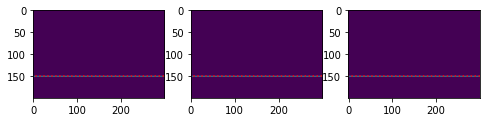

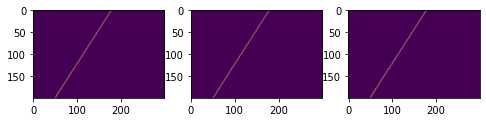

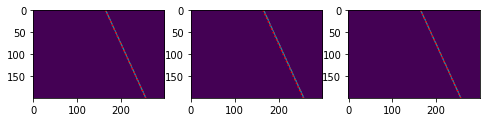

/home/derrior/HSE/Diploma/src/line_utils.py:42: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, F, [0], alpha=max(1, intensity), **default_parameters)


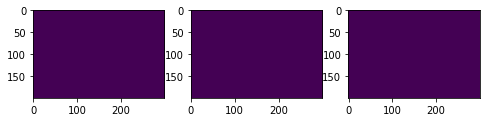

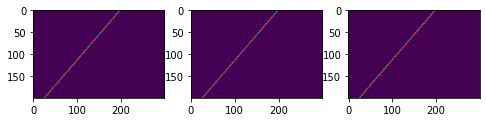

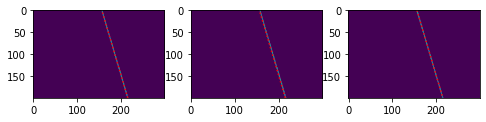

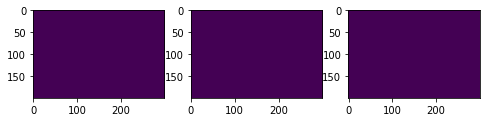

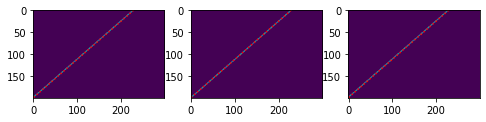

In [5]:
def test_draw(r, phi):
    plt.figure(figsize=(8, 5))
    plt.subplot(131)
    img = 255 - generate_image([Line(r, phi, 1, 0)])
    plt.imshow(img)
    abc = natural2abc((r, phi))
    draw_abc(abc)
    plt.subplot(132)

    plt.imshow(img)
    draw_r_phi((r, phi))
    plt.subplot(133)    
    plt.imshow(img)
    draw_r_phi(abc2natural(abc))
    plt.show()

test_draw(150, 0)
test_draw(150, 1)
test_draw(150, 2)
test_draw(150, 3)
test_draw(-150, 4)
test_draw(-150, 5)
test_draw(-150, 6)
test_draw(150, 7)

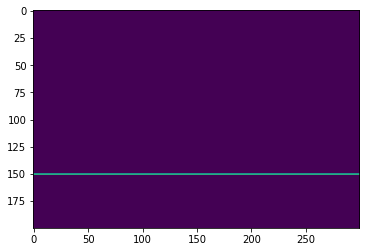

(150.0, 6.283185307179586)


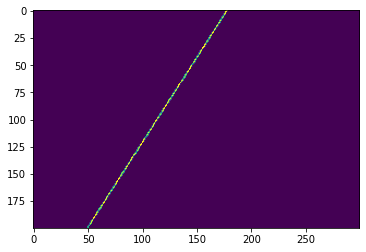

(149.30619953174147, 1.0002027199642518)


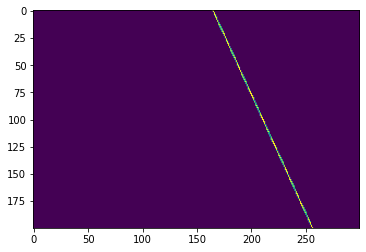

(149.75508826325654, 1.9999843039331007)


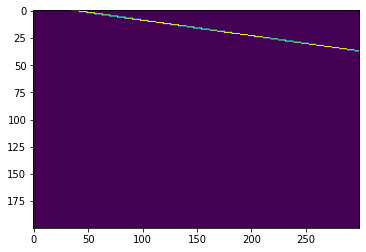

(5.41060068299645, 3.000075636646555)


In [6]:
"""
Testing polarization detection
"""
def test_one_line(r, phi, method: PolarizationMethod):
    img = 255 - generate_image([Line(r, phi, 1, 0)])
    plt.imshow(img)
    plt.show()
    cell = Cell(0, img.shape[0], 0, img.shape[1], img)
    result = method(cell)
    print(result)
    assert(is_same(result, (r, phi)))

test_one_line(150, 2 * pi, InertionPolarization())
test_one_line(150, 1, InertionPolarization())
test_one_line(150, 2, InertionPolarization())
test_one_line(5, 3, InertionPolarization())


(0.5403023058681398, 0.8414709848078965, -150)
(-0.5, 299.5)


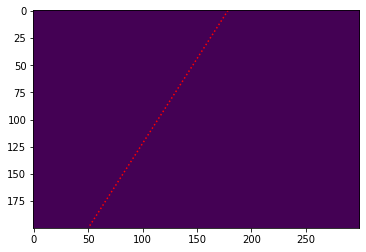

In [7]:
img = generate_image([])
print(natural2abc((150, 1)))
plt.imshow(img)
print(plt.gca().get_xlim())
draw_r_phi((150, 1))

miss cache
0.09549296585513722 1 12 14
0.09549296585513722 5 12 14
miss cache
total
1.6265409173334036 5 5 7
0.09549296585513722 8 12 14
miss cache
total
2.639349950858279 8 8 10
0.09549296585513722 8 12 14
total
2.639349950858279 8 8 10
0.09549296585513722 1 12 14


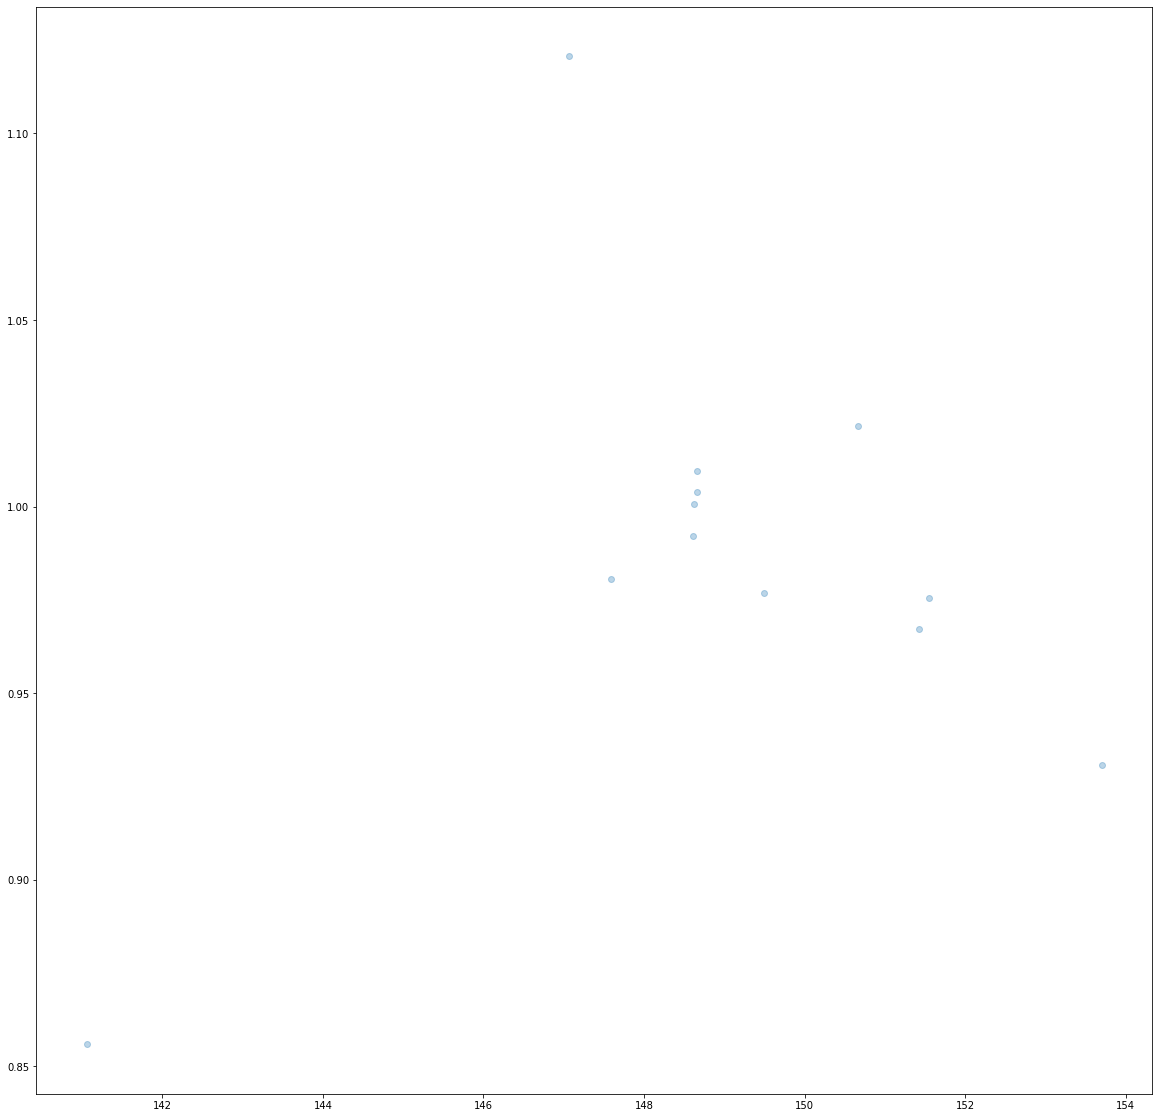

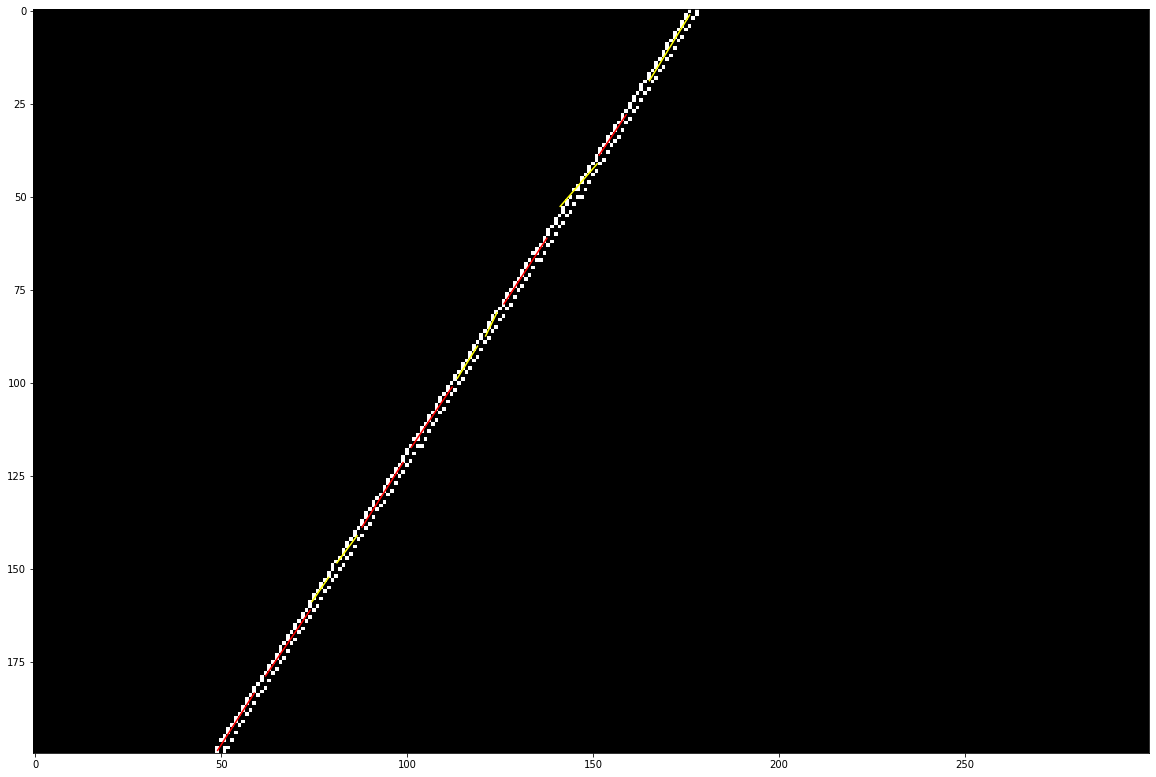

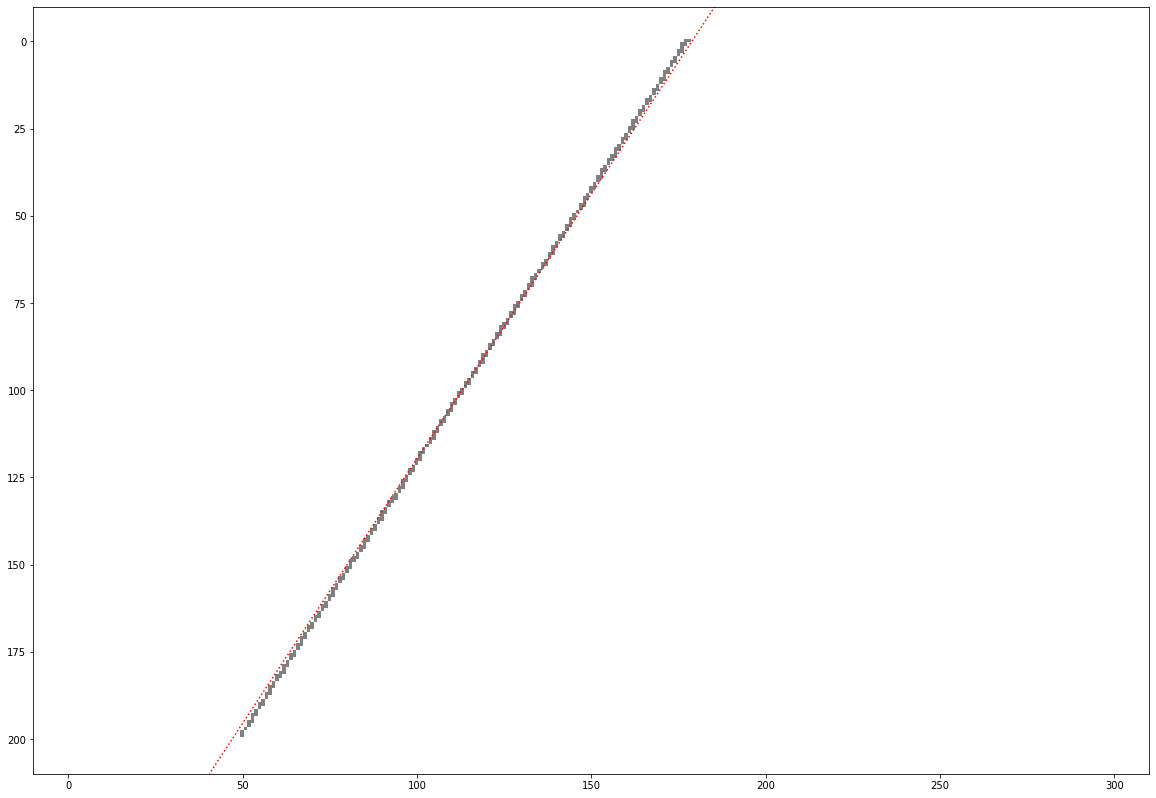

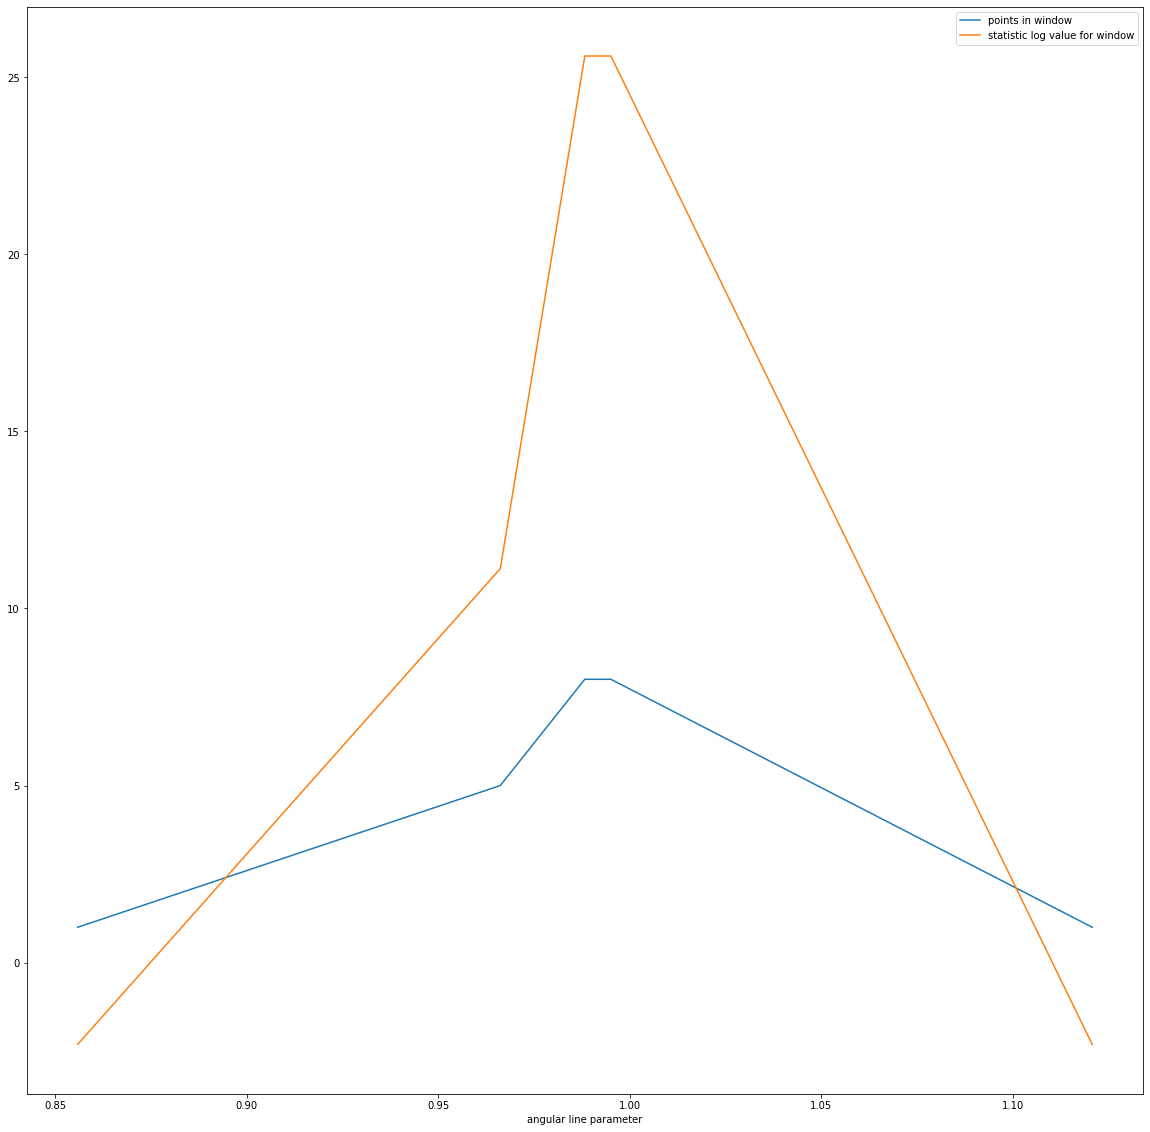

[((149.32735489357157, 0.9882585261048205), 0.002421054736403728)]


In [8]:
"""
Testing line detection
"""
def test_one_line(r, phi):
    img = generate_image([Line(r, phi, 1, 0)])
    edge = 255 - img
    exp_data = run_exp(img, polarization_method=MaxComponentInertionPolarization(11))
    exp_data.visualize(compact=False)
    print(exp_data.filtered_lines)
    
test_one_line(150, 1)

In [73]:
def count_line_error(l1, l2):
    return abs(l1[0] - l2[0]), min(abs(l1[1] - l2[1]), abs(abs(l1[1] - l2[1]) - 2 * pi))

def test_angle_accuracy(r, phi, h=200, w=300):
    img = generate_image([Line(r, phi, 1, 0)], h=h, w=w)
    edge = 255 - img
    grids = list(range(3, 40))
    exp_results = []
    top1_errors = []
    top3_errors = []
    for grid_size in grids:
        print("grid size: ", grid_size)
        exp_data = run_exp(img, grid_size=grid_size,
                           polarization_method=MaxComponentInertionPolarization(grid_size, max(2, grid_size // 2)),
                           peak_detection_method=NausWallenstein(r_window=10, phi_window=0.04))
        exp_results.append(exp_data)
        exp_data.visualize(compact=True)    
        
        peaks = list(exp_data.peaks.items())
        if len(peaks) == 0:
            errors.append((1, 1))
            continue
        lines = sorted(peaks, key=lambda x: x[1])[:3]
        total_error = [0, 0]
        for line in lines:
            new_err = count_line_error(line[0], (r, phi))
            total_error[0] += new_err[0]
            total_error[1] += new_err[1]
        total_error[0] /= len(lines)
        total_error[1] /= len(lines)
        top3_errors.append(total_error)
        top1_errors.append(count_line_error(lines[0][0], (r, phi)))
    #plt.plot(grids, list(map(lambda x: x[0], errors)), label="d-component error")
    plt.plot(grids, list(map(lambda x: x[1], top1_errors)), label="phi-component error, top-1")
    plt.plot(grids, list(map(lambda x: x[1], top3_errors)), label="phi-component error, top-3")
    plt.title("Ошибка определения угловой компоненты")
    plt.xlabel("grid size")
    plt.ylabel("error, rad")
    plt.legend()
    plt.show()

grid size:  3
miss cache
0.9994930426171028 9 157 159
miss cache
0.46535278728859325 2 9 11
0.46535278728859325 2 9 11
0.46535278728859325 2 9 11
0.46535278728859325 2 9 11
0.46535278728859325 1 9 11
0.46535278728859325 1 9 11
0.46535278728859325 2 9 11
0.9994930426171028 148 157 159
miss cache
9.801324503311259 50 148 150
9.801324503311259 55 148 150
9.801324503311259 55 148 150
9.801324503311259 58 148 150
9.801324503311259 60 148 150
9.801324503311259 56 148 150
9.801324503311259 56 148 150
9.801324503311259 58 148 150
9.801324503311259 54 148 150
9.801324503311259 54 148 150
9.801324503311259 56 148 150
9.801324503311259 52 148 150
9.801324503311259 52 148 150
9.801324503311259 54 148 150
9.801324503311259 50 148 150
9.801324503311259 51 148 150
9.801324503311259 53 148 150
9.801324503311259 50 148 150
9.801324503311259 51 148 150
9.801324503311259 53 148 150
9.801324503311259 49 148 150
9.801324503311259 47 148 150
9.801324503311259 46 148 150


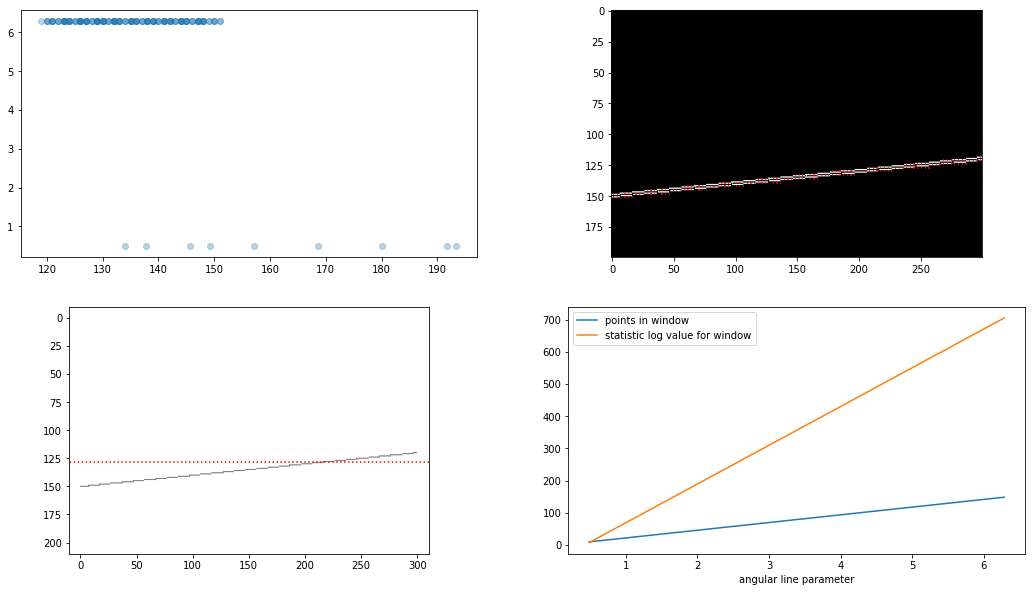

grid size:  4
miss cache
0.7066479473280154 13 111 113
miss cache
0.6808609425459387 5 13 15
0.6808609425459387 5 13 15
0.6808609425459387 2 13 15
0.6808609425459387 4 13 15
0.6808609425459387 4 13 15
0.6808609425459387 2 13 15
0.7066479473280154 3 111 113
0.7066479473280154 82 111 113
miss cache
5.503355704697986 28 82 84
5.503355704697986 29 82 84
5.503355704697986 29 82 84
5.503355704697986 30 82 84
5.503355704697986 31 82 84
5.503355704697986 31 82 84
5.503355704697986 29 82 84
5.503355704697986 30 82 84
5.503355704697986 30 82 84
5.503355704697986 30 82 84
5.503355704697986 28 82 84
5.503355704697986 29 82 84
5.503355704697986 30 82 84
5.503355704697986 30 82 84
5.503355704697986 28 82 84
5.503355704697986 29 82 84
5.503355704697986 30 82 84
5.503355704697986 30 82 84
5.503355704697986 28 82 84
5.503355704697986 30 82 84
5.503355704697986 31 82 84
0.7066479473280154 13 111 113
0.6808609425459387 5 13 15
0.6808609425459387 5 13 15
0.6808609425459387 2 13 15
0.6808609425459387 4 13 

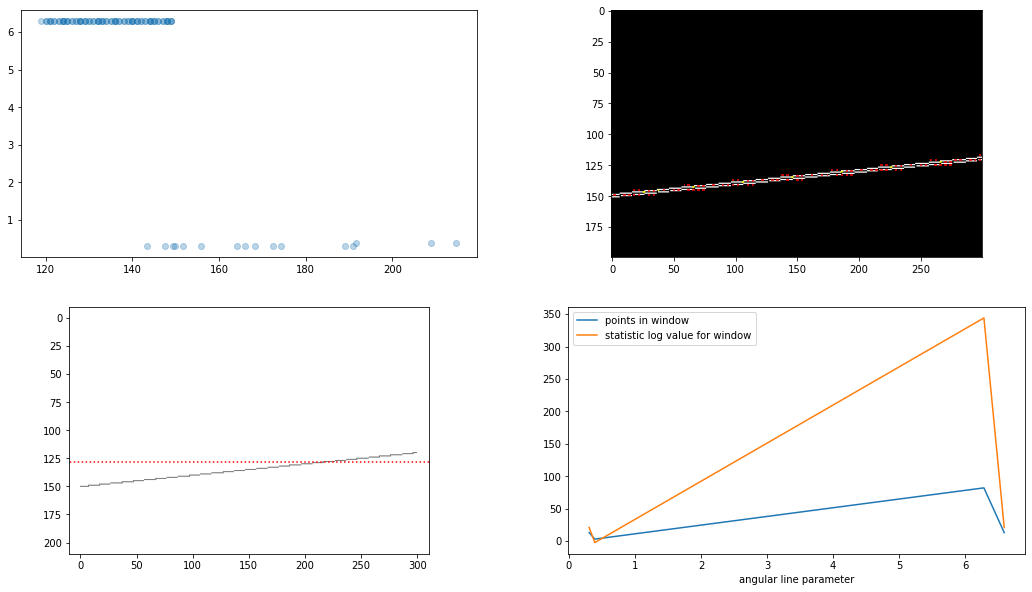

grid size:  5
miss cache
0.6047887837492023 4 95 97
0.6047887837492023 15 95 97
miss cache
0.7669377182736429 4 15 17
0.7669377182736429 5 15 17
0.7669377182736429 4 15 17
0.7669377182736429 4 15 17
0.7669377182736429 4 15 17
0.7669377182736429 4 15 17
0.7669377182736429 3 15 17
0.7669377182736429 3 15 17
0.7669377182736429 3 15 17
0.7669377182736429 3 15 17
0.6047887837492023 57 95 97
miss cache
3.774834437086093 17 57 59
3.774834437086093 18 57 59
3.774834437086093 19 57 59
3.774834437086093 18 57 59
3.774834437086093 18 57 59
3.774834437086093 19 57 59
3.774834437086093 20 57 59
3.774834437086093 20 57 59
3.774834437086093 18 57 59
3.774834437086093 18 57 59
3.774834437086093 19 57 59
3.774834437086093 21 57 59
3.774834437086093 21 57 59
3.774834437086093 20 57 59
3.774834437086093 20 57 59
3.774834437086093 21 57 59
3.774834437086093 23 57 59
3.774834437086093 22 57 59
3.774834437086093 21 57 59
3.774834437086093 21 57 59
3.774834437086093 21 57 59
3.774834437086093 22 57 59
3.7748

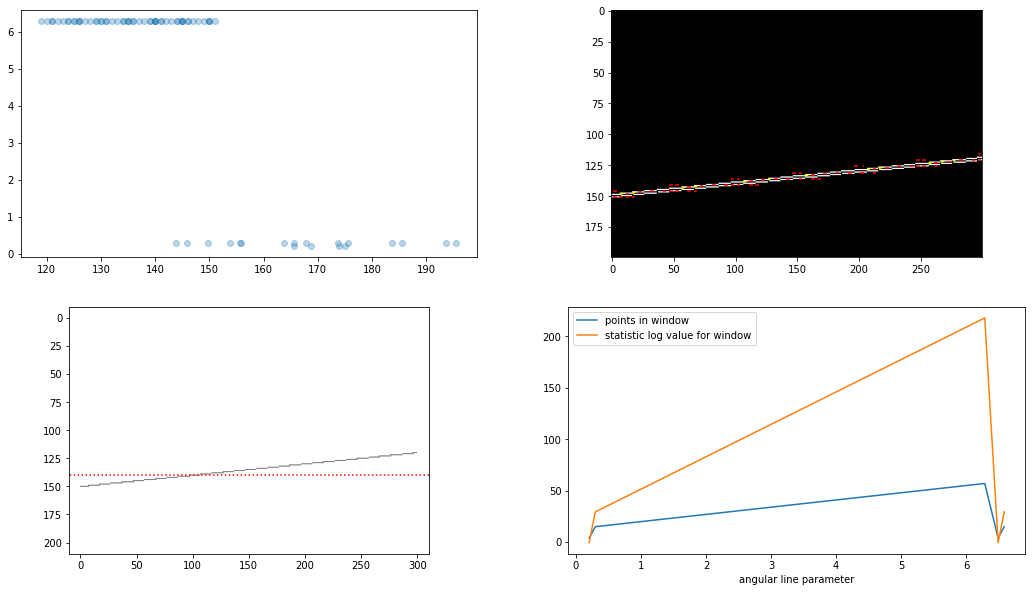

grid size:  6
miss cache
0.4138028520389279 7 65 67
miss cache
total
0.4563731908107107 7 7 9
0.4138028520389279 1 65 67
0.4138028520389279 49 65 67
miss cache
3.2450331125827816 17 49 51
3.2450331125827816 18 49 51
3.2450331125827816 19 49 51
3.2450331125827816 20 49 51
3.2450331125827816 20 49 51
3.2450331125827816 20 49 51
3.2450331125827816 19 49 51
3.2450331125827816 18 49 51
3.2450331125827816 17 49 51
3.2450331125827816 18 49 51
3.2450331125827816 18 49 51
3.2450331125827816 18 49 51
3.2450331125827816 17 49 51
3.2450331125827816 16 49 51
3.2450331125827816 15 49 51
3.2450331125827816 17 49 51
3.2450331125827816 17 49 51
3.2450331125827816 17 49 51
3.2450331125827816 17 49 51
3.2450331125827816 13 49 51
3.2450331125827816 14 49 51
3.2450331125827816 14 49 51
0.4138028520389279 7 65 67
total
0.4563731908107107 7 7 9
0.4138028520389279 1 65 67


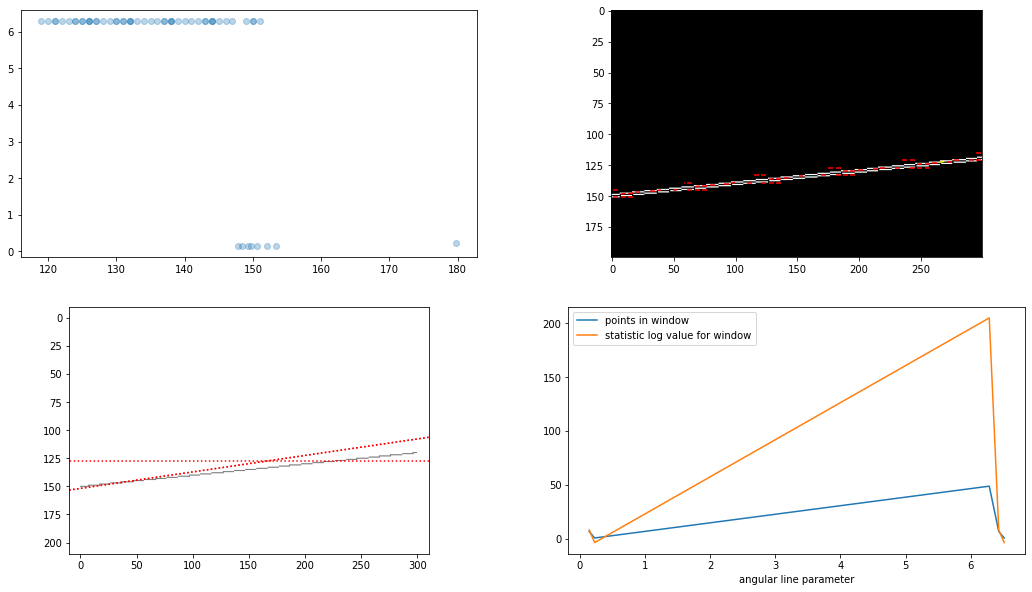

grid size:  7
miss cache
0.375605665696873 3 59 61
0.375605665696873 10 59 61
miss cache
0.5639994914451831 6 10 12
0.5639994914451831 5 10 12
0.5639994914451831 4 10 12
0.5639994914451831 1 10 12
0.375605665696873 5 59 61
0.375605665696873 31 59 61
miss cache
2.0805369127516777 11 31 33
2.0805369127516777 10 31 33
2.0805369127516777 10 31 33
2.0805369127516777 11 31 33
2.0805369127516777 11 31 33
2.0805369127516777 9 31 33
2.0805369127516777 11 31 33
2.0805369127516777 13 31 33
2.0805369127516777 12 31 33
2.0805369127516777 12 31 33
2.0805369127516777 13 31 33
2.0805369127516777 13 31 33
0.375605665696873 3 59 61
0.375605665696873 10 59 61
0.5639994914451831 6 10 12
0.5639994914451831 5 10 12
0.5639994914451831 4 10 12
0.5639994914451831 1 10 12
0.375605665696873 5 59 61


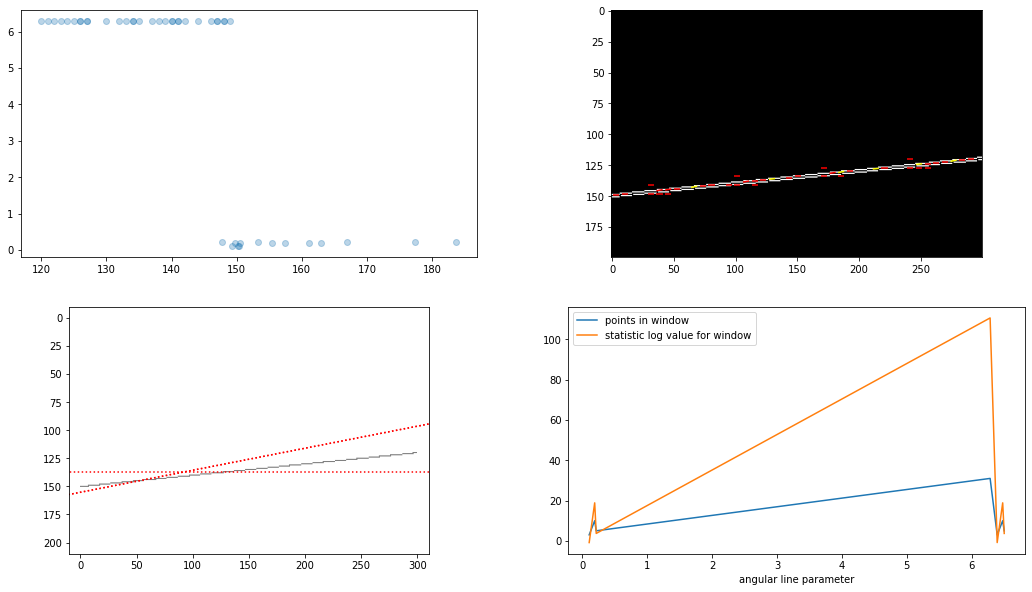

grid size:  8
miss cache
0.3310422816311423 5 52 54
0.3310422816311423 9 52 54
miss cache
0.5395563260094696 6 9 11
0.5395563260094696 6 9 11
0.5395563260094696 6 9 11
0.5395563260094696 6 9 11
0.3310422816311423 7 52 54
miss cache
0.40838514329749503 3 7 9
0.40838514329749503 3 7 9
0.40838514329749503 4 7 9
0.40838514329749503 3 7 9
0.3310422816311423 22 52 54
miss cache
1.4864864864864864 8 22 24
1.4864864864864864 8 22 24
1.4864864864864864 10 22 24
1.4864864864864864 10 22 24
1.4864864864864864 8 22 24
1.4864864864864864 11 22 24
1.4864864864864864 11 22 24
1.4864864864864864 8 22 24
0.3310422816311423 5 52 54
0.3310422816311423 9 52 54
0.5395563260094696 6 9 11
0.5395563260094696 6 9 11
0.5395563260094696 6 9 11
0.5395563260094696 6 9 11
0.3310422816311423 7 52 54
0.40838514329749503 3 7 9
0.40838514329749503 3 7 9
0.40838514329749503 4 7 9
0.40838514329749503 3 7 9


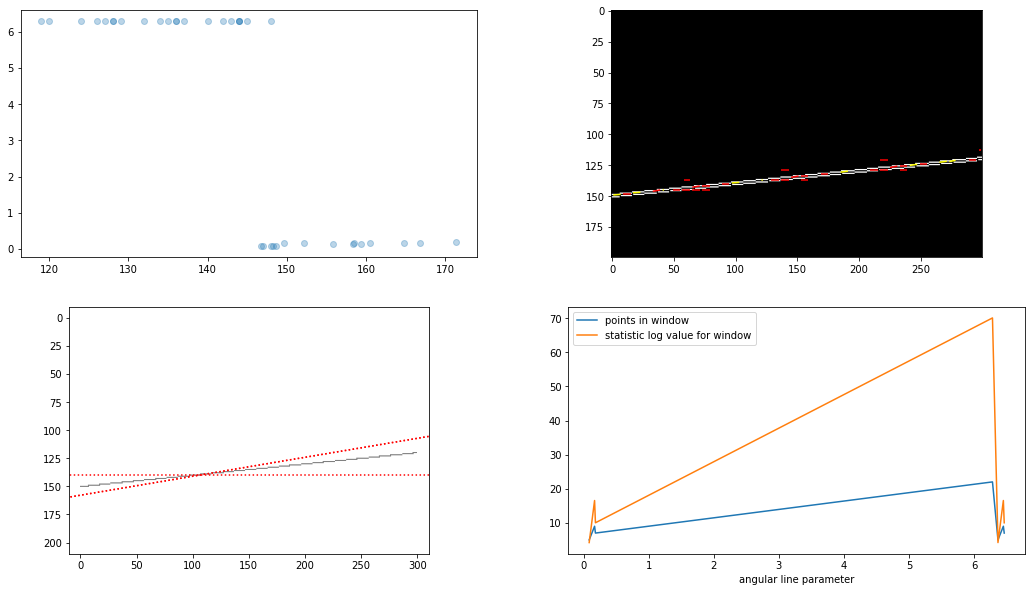

grid size:  9
miss cache
0.3119436884601149 4 49 51
0.3119436884601149 6 49 51
miss cache
0.3718329059200815 4 6 8
0.3718329059200815 3 6 8
0.3119436884601149 7 49 51
miss cache
0.42473388413713226 6 7 9
0.42473388413713226 6 7 9
0.3119436884601149 21 49 51
miss cache
1.4285714285714286 10 21 23
1.4285714285714286 10 21 23
1.4285714285714286 10 21 23
1.4285714285714286 9 21 23
1.4285714285714286 8 21 23
1.4285714285714286 8 21 23
1.4285714285714286 9 21 23
1.4285714285714286 9 21 23
1.4285714285714286 9 21 23
1.4285714285714286 9 21 23
0.3119436884601149 4 49 51
0.3119436884601149 6 49 51
0.3718329059200815 4 6 8
0.3718329059200815 3 6 8
0.3119436884601149 7 49 51
0.42473388413713226 6 7 9
0.42473388413713226 6 7 9


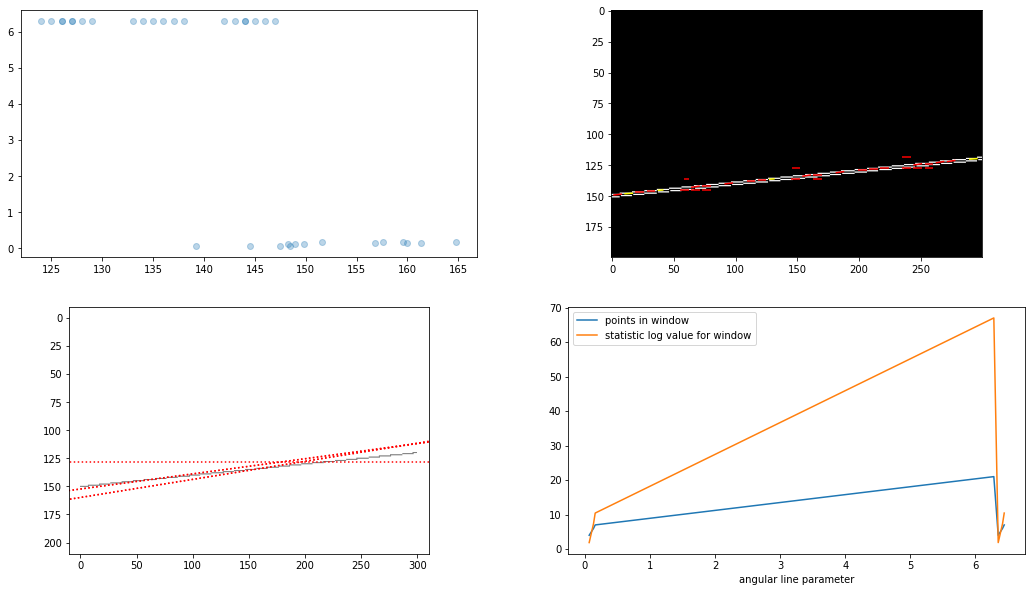

grid size:  10
miss cache
0.2355493157760051 15 37 39
miss cache
0.9367478913581285 12 15 17
0.9367478913581285 11 15 17
0.9367478913581285 10 15 17
0.9367478913581285 10 15 17
0.2355493157760051 7 37 39
miss cache
0.46357615894039733 2 7 9
0.46357615894039733 4 7 9
0.46357615894039733 3 7 9
0.46357615894039733 2 7 9
0.2355493157760051 15 37 39
0.9367478913581285 12 15 17
0.9367478913581285 11 15 17
0.9367478913581285 10 15 17
0.9367478913581285 10 15 17


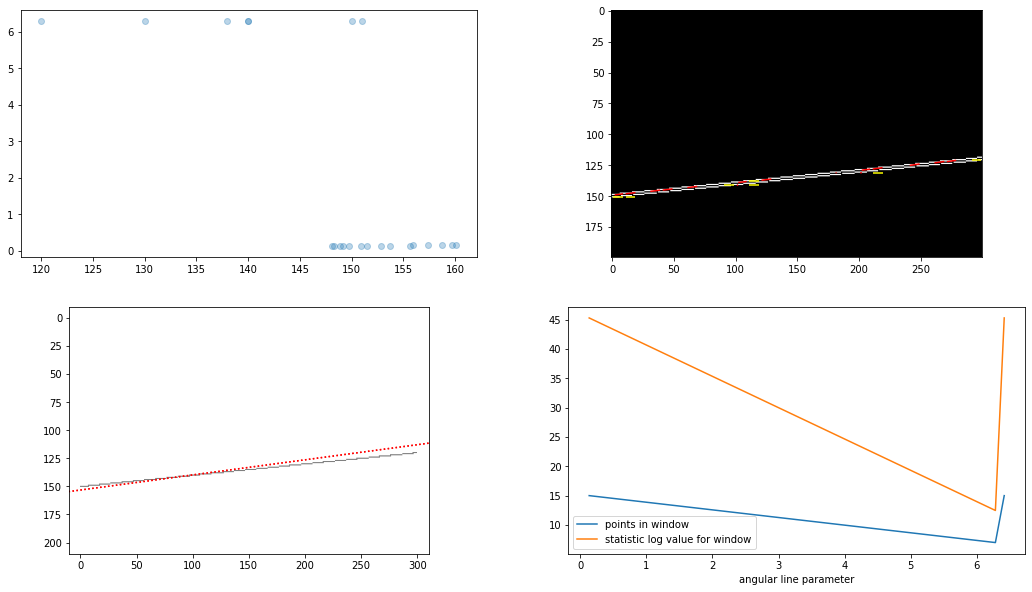

grid size:  11
miss cache
0.20371832715762606 5 32 34
miss cache
0.34015831950121345 3 5 7
0.34015831950121345 3 5 7
0.34015831950121345 3 5 7
0.20371832715762606 3 32 34
0.20371832715762606 7 32 34
miss cache
total
0.45234034812455504 7 7 9
0.20371832715762606 8 32 34
miss cache
0.5555555555555556 3 8 10
0.5555555555555556 3 8 10
0.5555555555555556 4 8 10
0.5555555555555556 4 8 10
0.5555555555555556 4 8 10
0.20371832715762606 5 32 34
0.34015831950121345 3 5 7
0.34015831950121345 3 5 7
0.34015831950121345 3 5 7
0.20371832715762606 3 32 34
0.20371832715762606 7 32 34
total
0.45234034812455504 7 7 9


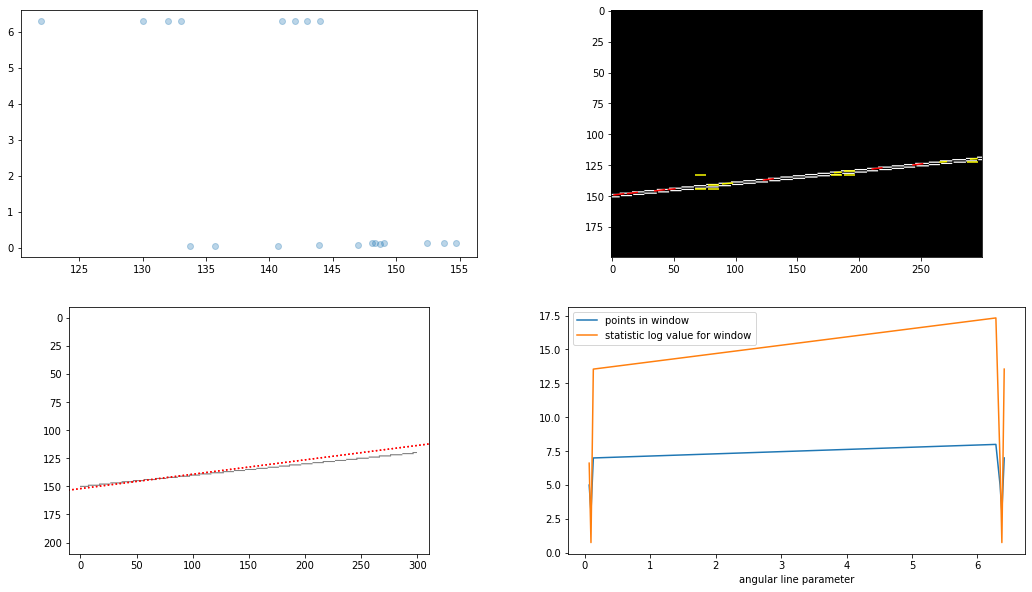

grid size:  12
miss cache
0.13369015219719207 2 21 23
0.13369015219719207 6 21 23
miss cache
total
0.3887800383093299 6 6 8
0.13369015219719207 5 21 23
miss cache
0.3448275862068966 2 5 7
0.3448275862068966 2 5 7
0.3448275862068966 2 5 7
0.3448275862068966 2 5 7
0.13369015219719207 2 21 23
0.13369015219719207 6 21 23
total
0.3887800383093299 6 6 8


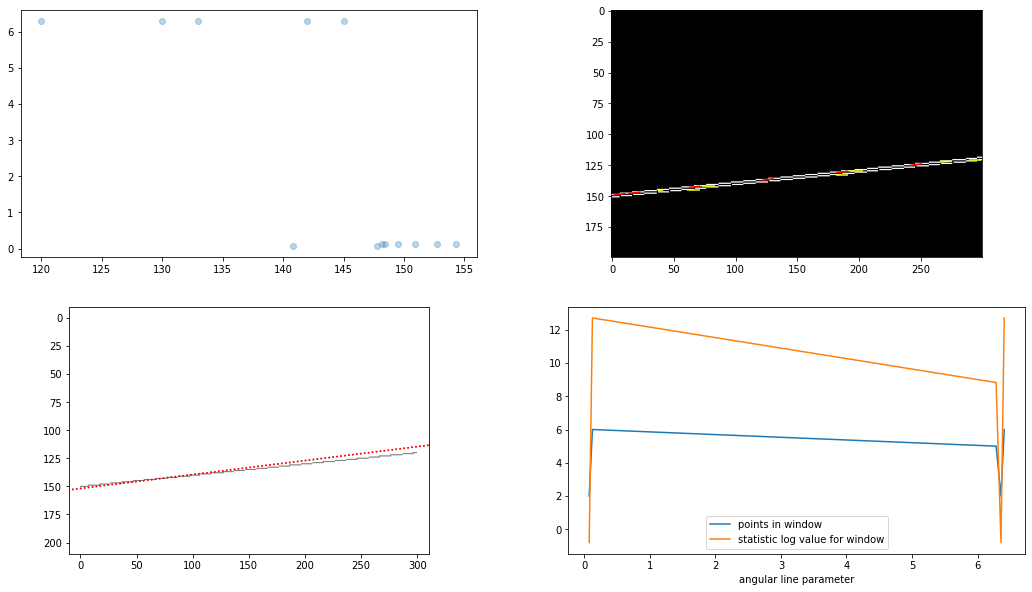

grid size:  13
miss cache
0.27374650211806 4 43 45
0.27374650211806 5 43 45
miss cache
total
0.33860871380205454 5 5 7
0.27374650211806 5 43 45
miss cache
total
0.3367910473485457 5 5 7
0.27374650211806 14 43 45
miss cache
total
0.918998689804985 14 14 16
0.27374650211806 14 43 45
miss cache
total
0.9057167112227433 14 14 16
0.27374650211806 4 43 45
0.27374650211806 4 43 45
0.27374650211806 5 43 45
total
0.33860871380205454 5 5 7
0.27374650211806 5 43 45
total
0.3367910473485457 5 5 7
0.27374650211806 14 43 45
total
0.918998689804985 14 14 16
0.27374650211806 14 43 45
total
0.9057167112227433 14 14 16


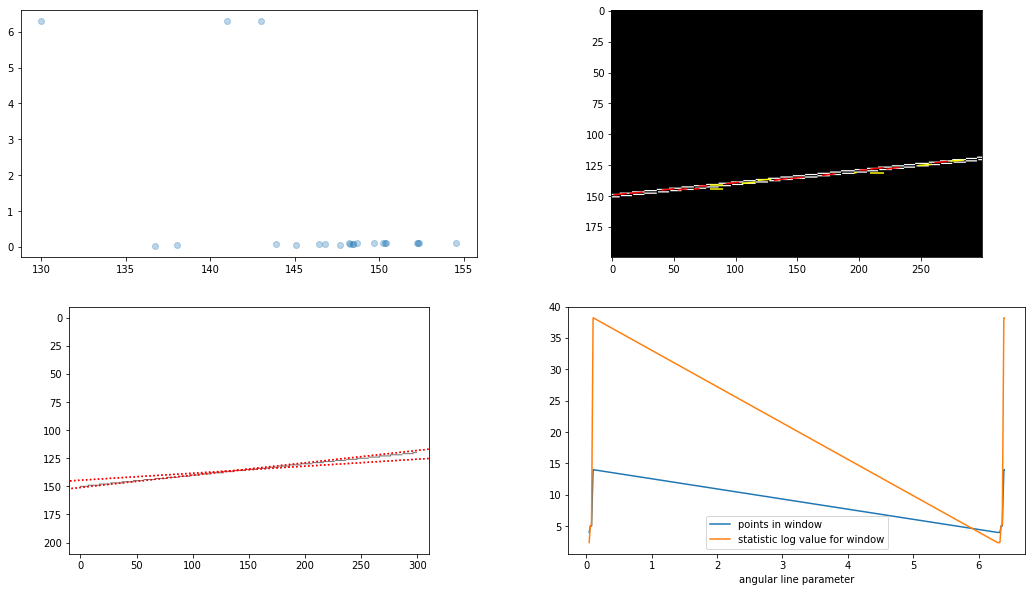

grid size:  14
miss cache
0.2355493157760051 1 37 39
0.2355493157760051 16 37 39
miss cache
total
1.0425596538433077 16 16 18
0.2355493157760051 4 37 39
0.2355493157760051 16 37 39
total
1.0425596538433077 16 16 18


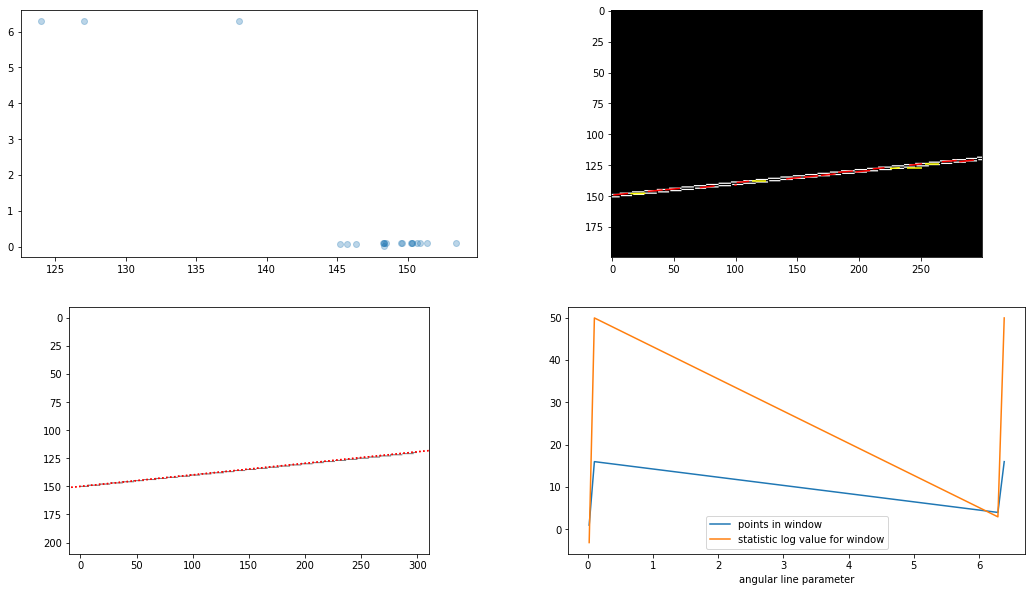

grid size:  15
miss cache
0.2610141066707084 8 41 43
miss cache
total
0.5373139315590577 8 8 10
0.2610141066707084 14 41 43
miss cache
total
0.9304598160816553 14 14 16
0.2610141066707084 15 41 43
miss cache
total
0.9794249751091363 15 15 17
0.2610141066707084 1 41 43
0.2610141066707084 1 41 43
0.2610141066707084 8 41 43
total
0.5373139315590577 8 8 10
0.2610141066707084 14 41 43
total
0.9304598160816553 14 14 16
0.2610141066707084 15 41 43
total
0.9794249751091363 15 15 17
0.2610141066707084 1 41 43


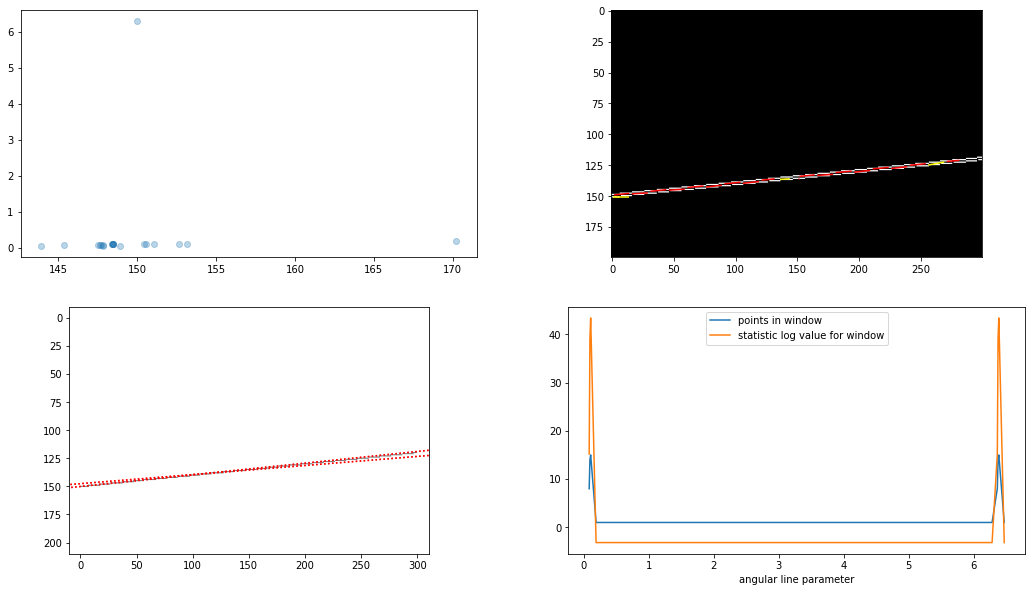

grid size:  16
miss cache
0.25464790894703254 3 40 42
0.25464790894703254 6 40 42
miss cache
0.40249021919780986 5 6 8
0.40249021919780986 5 6 8
0.25464790894703254 12 40 42
miss cache
total
0.7907879953776783 12 12 14
0.25464790894703254 11 40 42
miss cache
total
0.7227264978869141 11 11 13
0.25464790894703254 2 40 42
0.25464790894703254 5 40 42
miss cache
0.3448275862068966 3 5 7
0.3448275862068966 2 5 7
0.25464790894703254 3 40 42
0.25464790894703254 6 40 42
0.40249021919780986 5 6 8
0.40249021919780986 5 6 8
0.25464790894703254 12 40 42
total
0.7907879953776783 12 12 14
0.25464790894703254 11 40 42
total
0.7227264978869141 11 11 13
0.25464790894703254 2 40 42


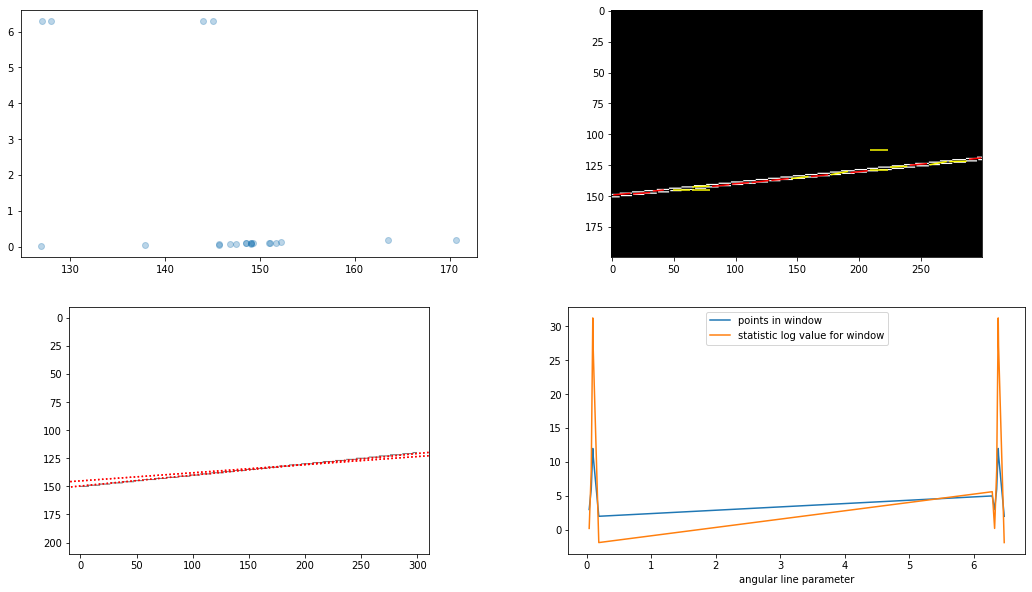

grid size:  17
miss cache
0.24191551349968093 3 38 40
0.24191551349968093 9 38 40
miss cache
total
0.6035791412483252 9 9 11
0.24191551349968093 13 38 40
miss cache
total
0.8551416074137839 13 13 15
0.24191551349968093 11 38 40
miss cache
0.7049659310518287 10 11 13
0.7049659310518287 10 11 13
0.24191551349968093 3 38 40
0.24191551349968093 3 38 40
0.24191551349968093 9 38 40
total
0.6035791412483252 9 9 11
0.24191551349968093 13 38 40
total
0.8551416074137839 13 13 15
0.24191551349968093 11 38 40
0.7049659310518287 10 11 13
0.7049659310518287 10 11 13
0.24191551349968093 3 38 40


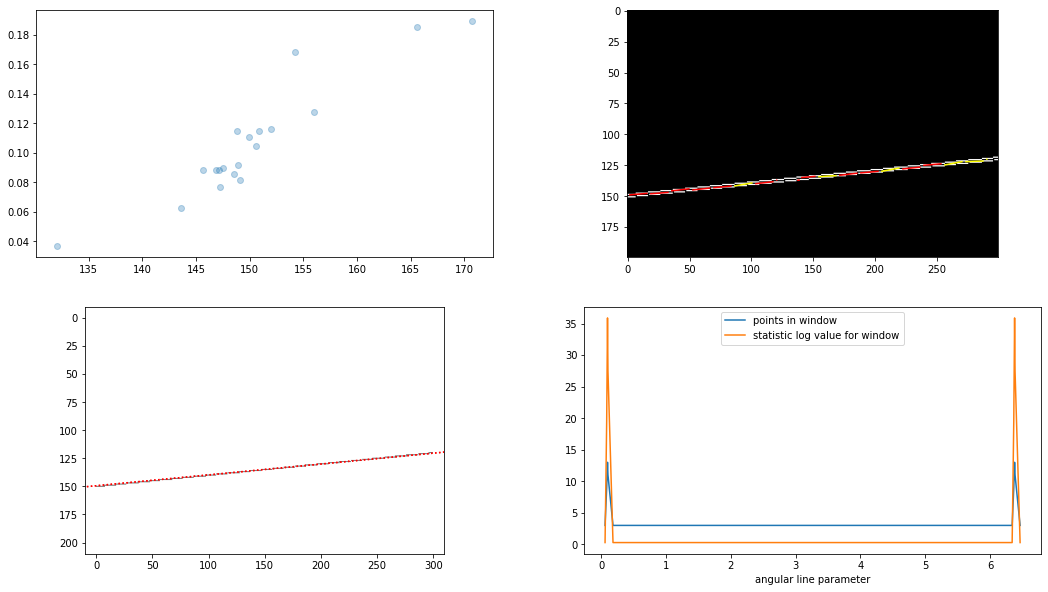

grid size:  18
miss cache
0.22918311805232927 3 36 38
0.22918311805232927 2 36 38
0.22918311805232927 7 36 38
miss cache
total
0.4690376721063552 7 7 9
0.22918311805232927 11 36 38
miss cache
total
0.7248889957628718 11 11 13
0.22918311805232927 12 36 38
miss cache
total
0.7883944856934874 12 12 14
0.22918311805232927 5 36 38
miss cache
0.3448275862068966 3 5 7
0.3448275862068966 2 5 7
0.3448275862068966 2 5 7
0.22918311805232927 2 36 38
0.22918311805232927 7 36 38
total
0.4690376721063552 7 7 9
0.22918311805232927 11 36 38
total
0.7248889957628718 11 11 13
0.22918311805232927 12 36 38
total
0.7883944856934874 12 12 14


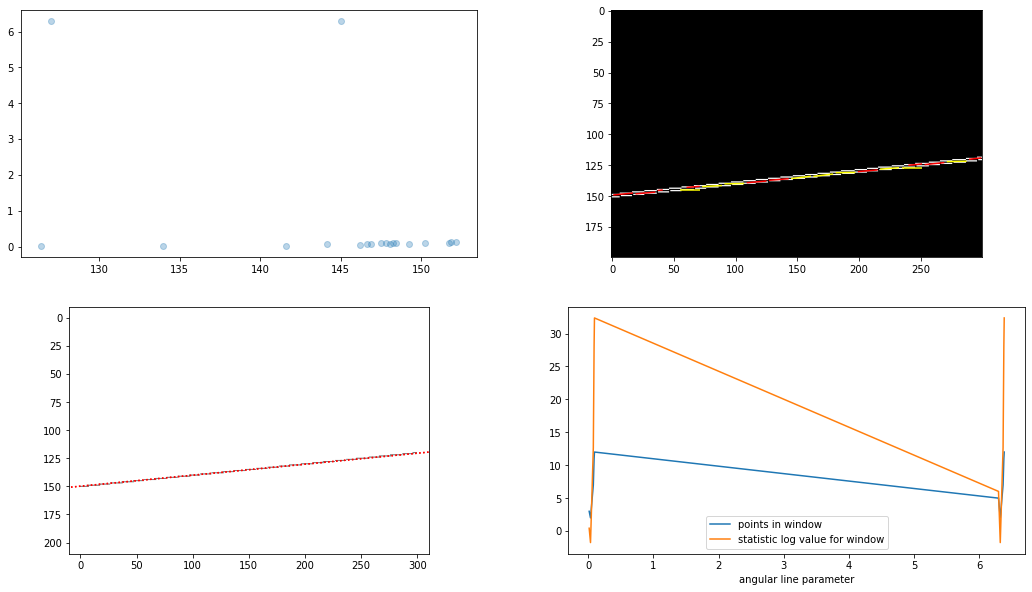

grid size:  19
miss cache
0.20371832715762606 1 32 34
0.20371832715762606 12 32 34
miss cache
total
0.795977524880015 12 12 14
0.20371832715762606 11 32 34
miss cache
total
0.7252081265652792 11 11 13
0.20371832715762606 9 32 34
miss cache
total
0.5927484529297691 9 9 11
0.20371832715762606 1 32 34
0.20371832715762606 1 32 34
0.20371832715762606 12 32 34
total
0.795977524880015 12 12 14
0.20371832715762606 11 32 34
total
0.7252081265652792 11 11 13
0.20371832715762606 9 32 34
total
0.5927484529297691 9 9 11
0.20371832715762606 1 32 34


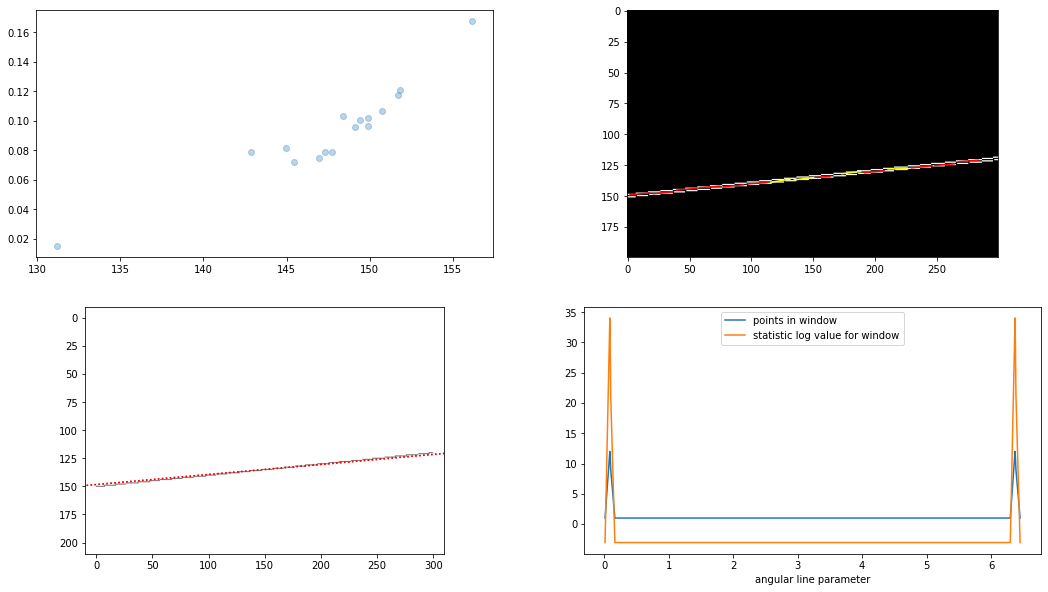

grid size:  20
miss cache
0.20371832715762606 6 32 34
miss cache
0.40870959484616104 4 6 8
0.40870959484616104 5 6 8
0.20371832715762606 4 32 34
0.20371832715762606 8 32 34
miss cache
total
0.5277152512496461 8 8 10
0.20371832715762606 8 32 34
total
0.5277152512496461 8 8 10
0.20371832715762606 6 32 34
miss cache
total
0.37838242647821796 6 6 8
0.20371832715762606 6 32 34
0.40870959484616104 4 6 8
0.40870959484616104 5 6 8
0.20371832715762606 4 32 34
0.20371832715762606 8 32 34
total
0.5277152512496461 8 8 10
0.20371832715762606 8 32 34
total
0.5277152512496461 8 8 10
0.20371832715762606 6 32 34
total
0.37838242647821796 6 6 8


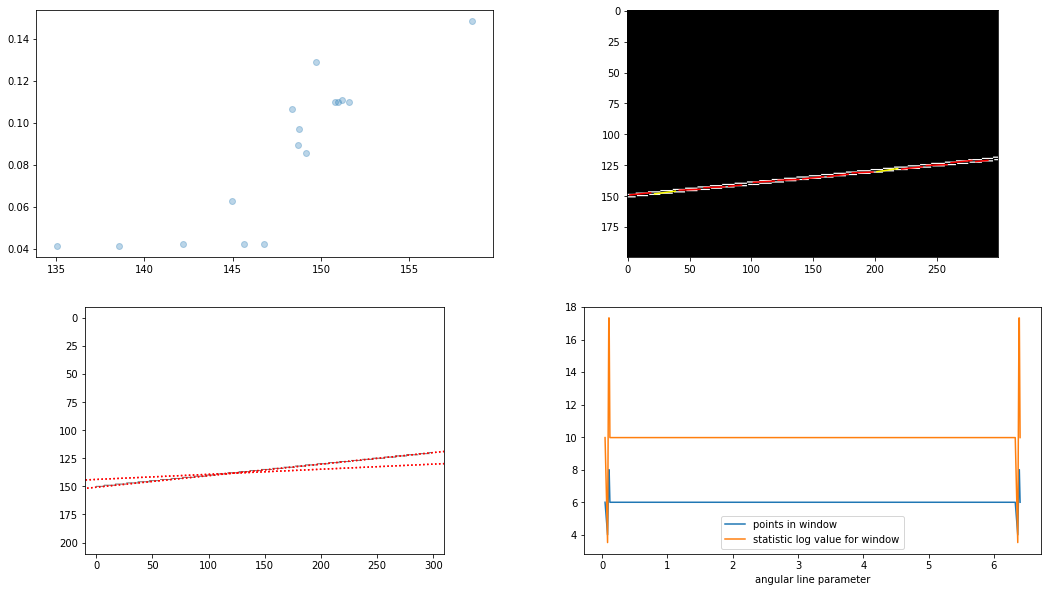

grid size:  21
miss cache
0.1909859317102744 6 30 32
miss cache
total
0.406250855607234 6 6 8
0.1909859317102744 8 30 32
miss cache
total
0.5362354755857307 8 8 10
0.1909859317102744 8 30 32
miss cache
0.5318062104555611 7 8 10
0.5318062104555611 7 8 10
0.1909859317102744 7 30 32
miss cache
total
0.4653304341486159 7 7 9
0.1909859317102744 8 30 32
miss cache
total
0.5150280641684486 8 8 10
0.1909859317102744 3 30 32
0.1909859317102744 2 30 32
0.1909859317102744 6 30 32
total
0.406250855607234 6 6 8
0.1909859317102744 8 30 32
total
0.5362354755857307 8 8 10
0.1909859317102744 8 30 32
0.5318062104555611 7 8 10
0.5318062104555611 7 8 10
0.1909859317102744 7 30 32
total
0.4653304341486159 7 7 9
0.1909859317102744 8 30 32
total
0.5150280641684486 8 8 10
0.1909859317102744 3 30 32


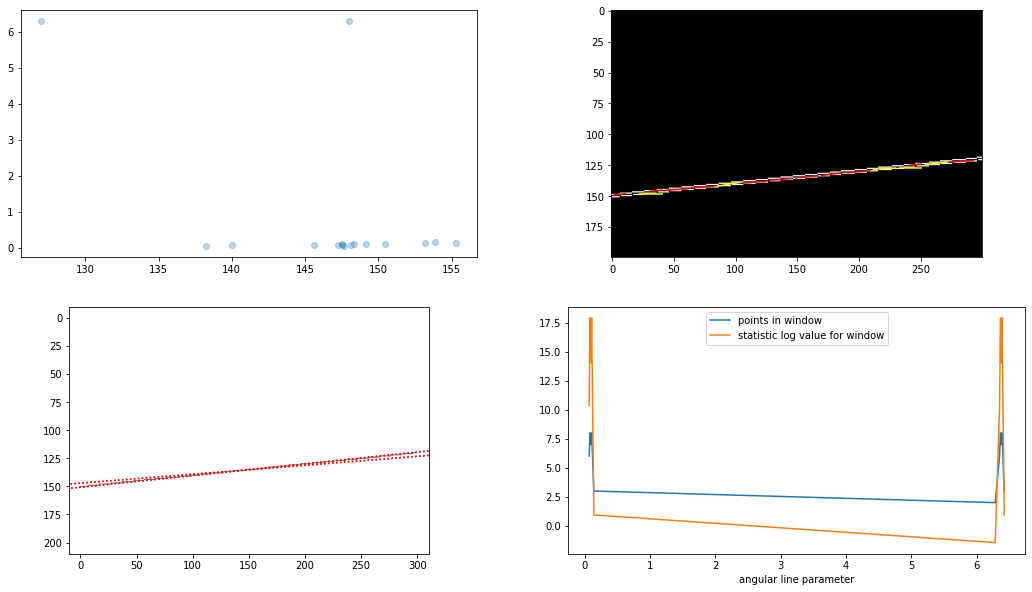

grid size:  22
miss cache
0.17188733853924698 4 27 29
0.17188733853924698 6 27 29
miss cache
total
0.4011459290383736 6 6 8
0.17188733853924698 6 27 29
total
0.4011459290383736 6 6 8
0.17188733853924698 6 27 29
miss cache
total
0.3958508867763038 6 6 8
0.17188733853924698 6 27 29
miss cache
total
0.386431626545844 6 6 8
0.17188733853924698 3 27 29
0.17188733853924698 2 27 29
0.17188733853924698 4 27 29
0.17188733853924698 6 27 29
total
0.4011459290383736 6 6 8
0.17188733853924698 6 27 29
total
0.4011459290383736 6 6 8
0.17188733853924698 6 27 29
total
0.3958508867763038 6 6 8
0.17188733853924698 6 27 29
total
0.386431626545844 6 6 8
0.17188733853924698 3 27 29


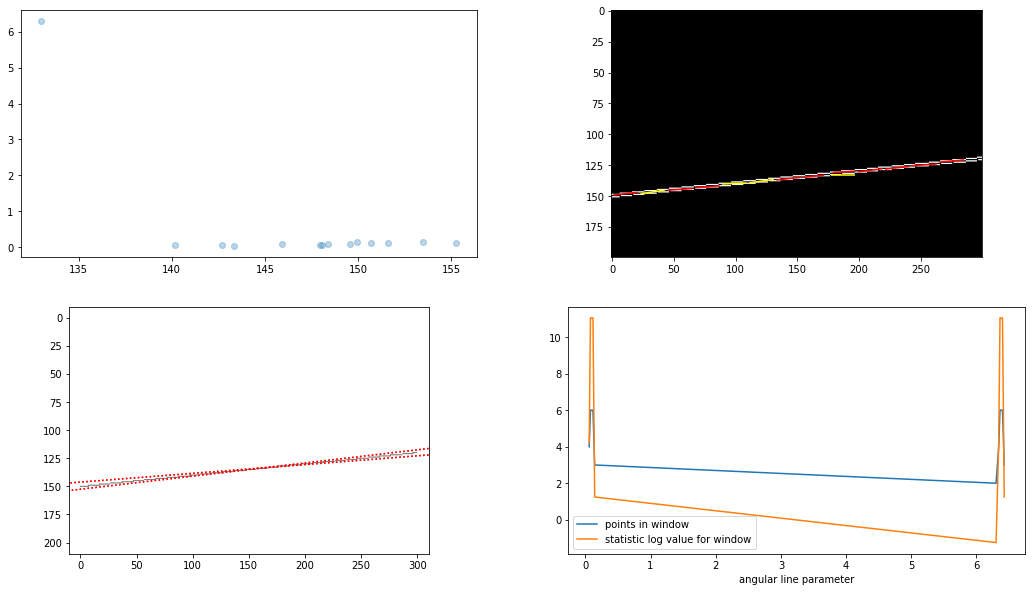

grid size:  23
miss cache
0.17188733853924698 4 27 29
0.17188733853924698 5 27 29
miss cache
total
0.3340522568578339 5 5 7
0.17188733853924698 7 27 29
miss cache
total
0.46402177289643765 7 7 9
0.17188733853924698 3 27 29
0.17188733853924698 2 27 29
0.17188733853924698 4 27 29
0.17188733853924698 5 27 29
total
0.3340522568578339 5 5 7
0.17188733853924698 7 27 29
total
0.46402177289643765 7 7 9
0.17188733853924698 3 27 29


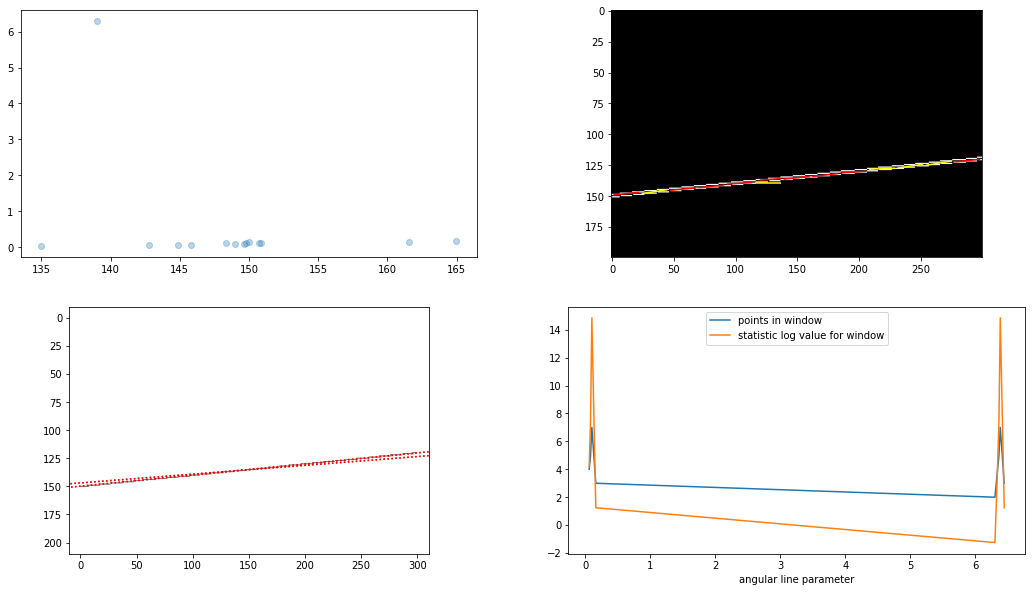

grid size:  24
miss cache
0.15915494309189535 4 25 27
0.15915494309189535 6 25 27
miss cache
total
0.40432147758552656 6 6 8
0.15915494309189535 7 25 27
miss cache
total
0.4670889733699203 7 7 9
0.15915494309189535 4 25 27
0.15915494309189535 2 25 27
0.15915494309189535 2 25 27
0.15915494309189535 4 25 27
0.15915494309189535 6 25 27
total
0.40432147758552656 6 6 8
0.15915494309189535 7 25 27
total
0.4670889733699203 7 7 9
0.15915494309189535 4 25 27
0.15915494309189535 2 25 27


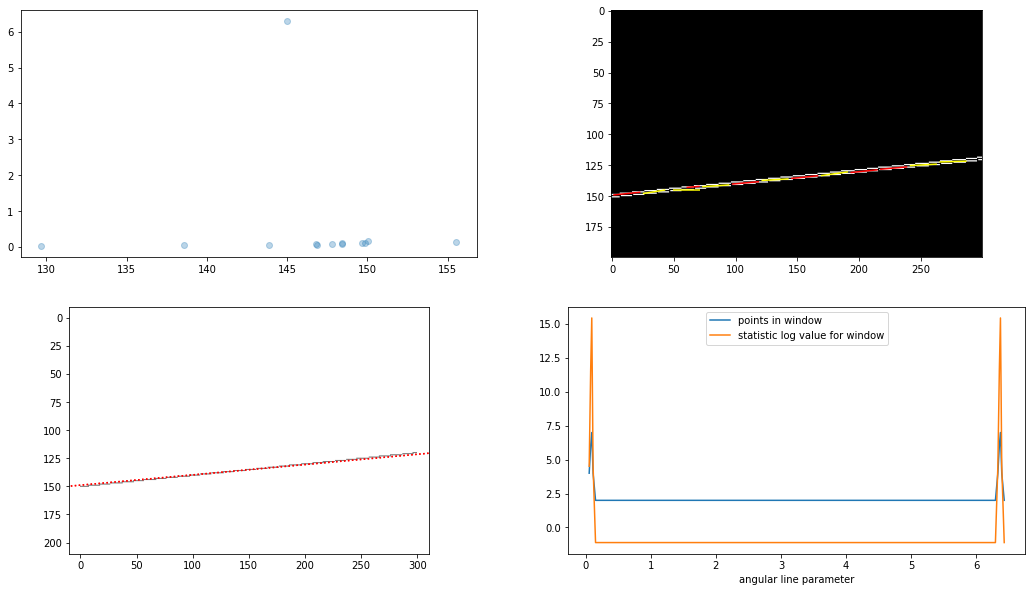

grid size:  25
miss cache
0.16552114081557115 10 26 28
miss cache
total
0.6590103853560197 10 10 12
0.16552114081557115 3 26 28
0.16552114081557115 3 26 28
0.16552114081557115 3 26 28
0.16552114081557115 10 26 28
total
0.6590103853560197 10 10 12
0.16552114081557115 3 26 28
0.16552114081557115 3 26 28
0.16552114081557115 3 26 28


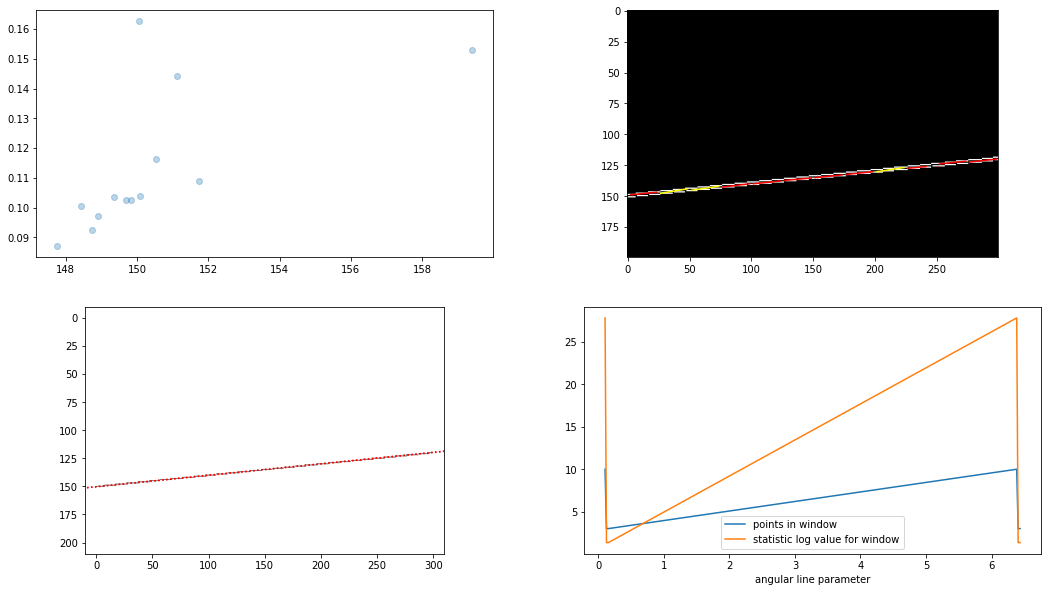

grid size:  26
miss cache
0.1400563499208679 1 22 24
0.1400563499208679 1 22 24
0.1400563499208679 8 22 24
miss cache
total
0.5279410618635877 8 8 10
0.1400563499208679 2 22 24
0.1400563499208679 1 22 24
0.1400563499208679 1 22 24
0.1400563499208679 8 22 24
total
0.5279410618635877 8 8 10
0.1400563499208679 2 22 24


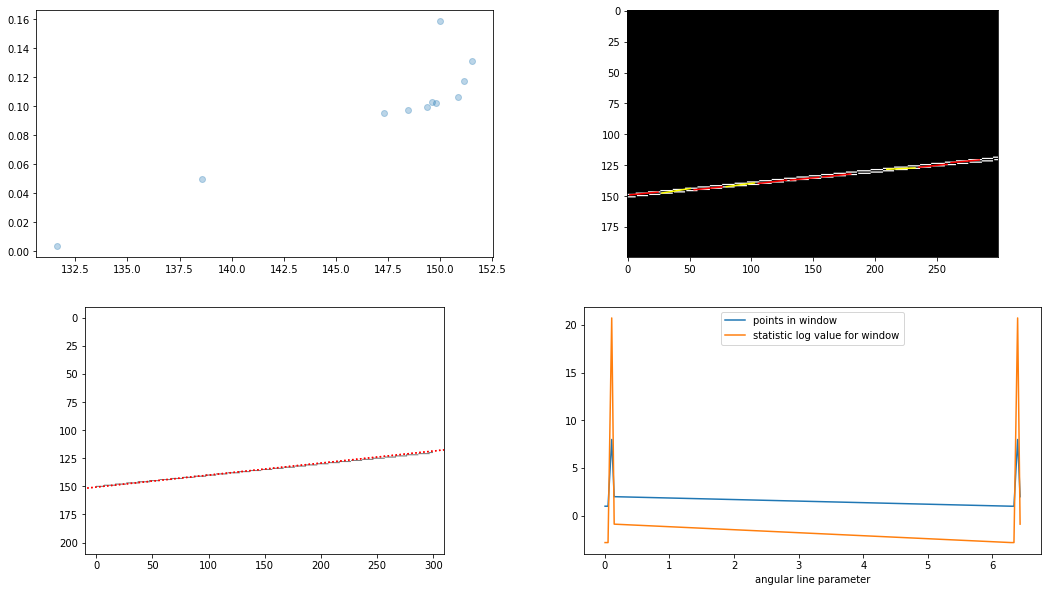

grid size:  27
miss cache
0.15278874536821951 2 24 26
0.15278874536821951 9 24 26
miss cache
total
0.6015543687593511 9 9 11
0.15278874536821951 9 24 26
miss cache
total
0.6009043396469758 9 9 11
0.15278874536821951 8 24 26
miss cache
total
0.5244099357140924 8 8 10
0.15278874536821951 2 24 26
0.15278874536821951 9 24 26
total
0.6015543687593511 9 9 11
0.15278874536821951 9 24 26
total
0.6009043396469758 9 9 11
0.15278874536821951 8 24 26
total
0.5244099357140924 8 8 10


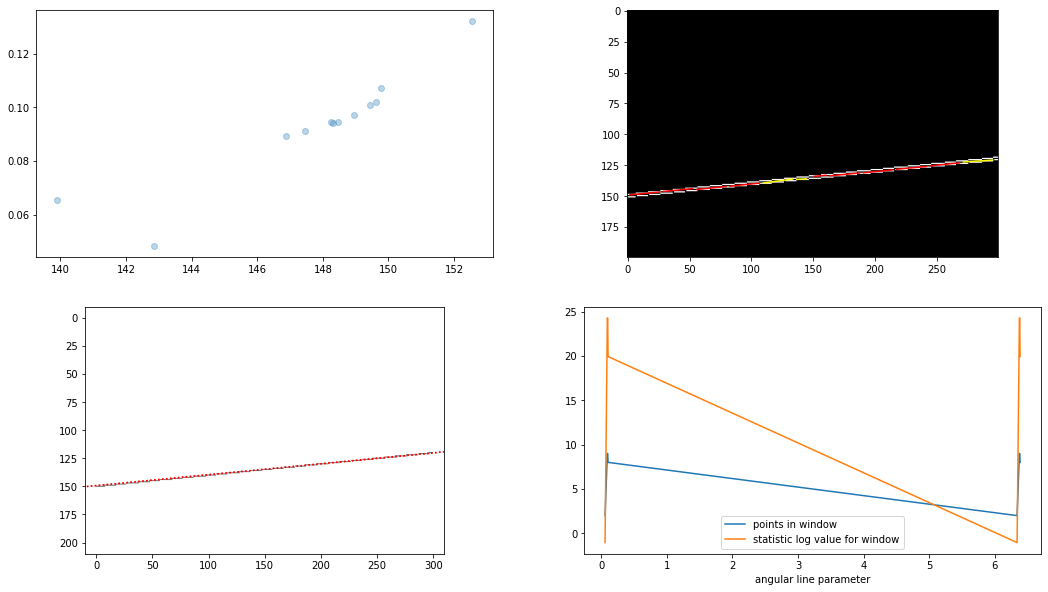

grid size:  28
miss cache
0.12732395447351627 2 20 22
0.12732395447351627 5 20 22
miss cache
total
0.33447641181655596 5 5 7
0.12732395447351627 5 20 22
miss cache
total
0.31850140855823483 5 5 7
0.12732395447351627 4 20 22
miss cache
total
0.2426884578360495 4 4 6
0.12732395447351627 2 20 22
0.12732395447351627 5 20 22
total
0.33447641181655596 5 5 7
0.12732395447351627 5 20 22
total
0.31850140855823483 5 5 7
0.12732395447351627 4 20 22
total
0.2426884578360495 4 4 6


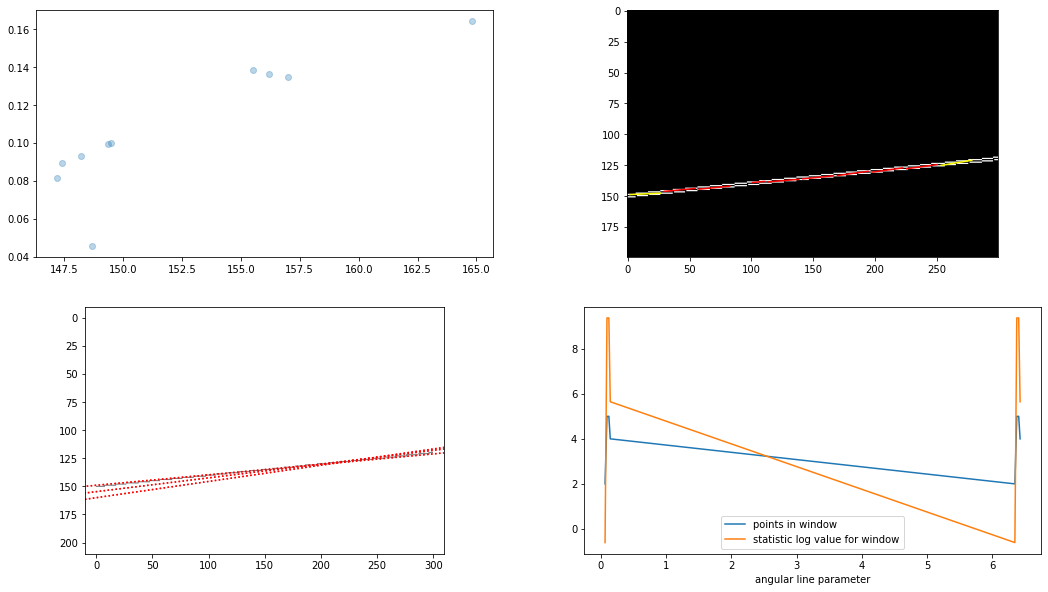

grid size:  29
miss cache
0.12732395447351627 5 20 22
miss cache
0.33626724181585804 2 5 7
0.33626724181585804 4 5 7
0.12732395447351627 6 20 22
miss cache
total
0.39709964848316176 6 6 8
0.12732395447351627 5 20 22
0.33626724181585804 2 5 7
0.33626724181585804 4 5 7
0.12732395447351627 6 20 22
total
0.39709964848316176 6 6 8


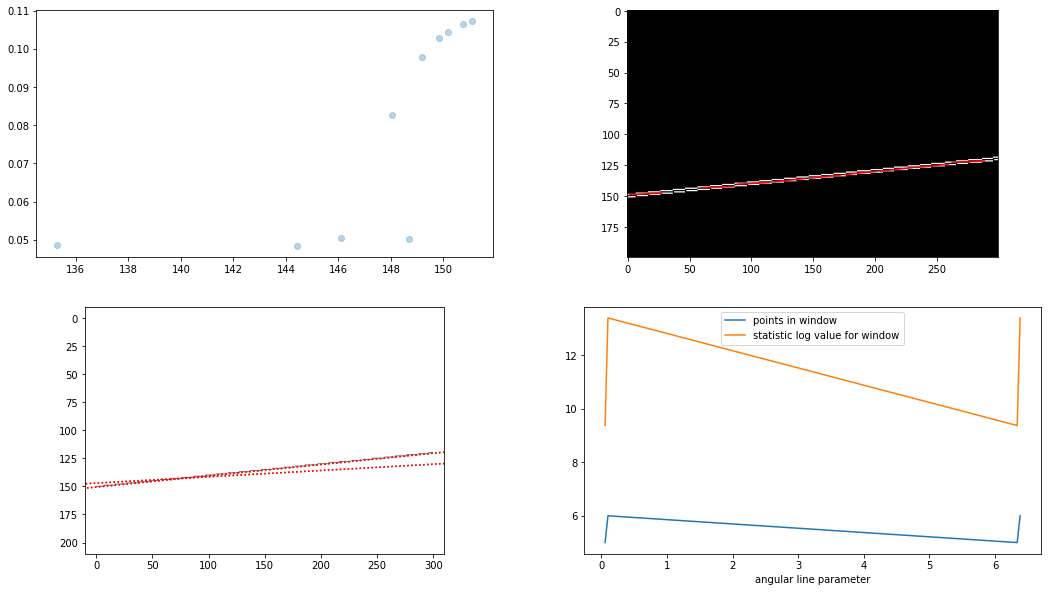

grid size:  30
miss cache
0.12732395447351627 9 20 22
miss cache
0.6052363794972783 6 9 11
0.6052363794972783 8 9 11
0.12732395447351627 7 20 22
miss cache
total
0.46644122222525525 7 7 9
0.12732395447351627 9 20 22
0.6052363794972783 6 9 11
0.6052363794972783 8 9 11
0.12732395447351627 7 20 22
total
0.46644122222525525 7 7 9


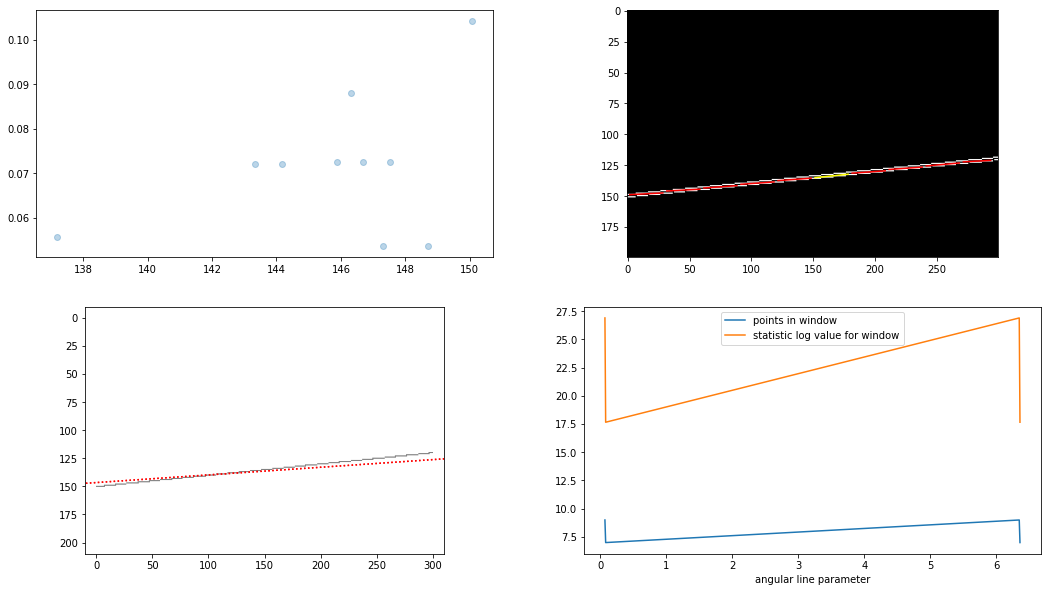

grid size:  31
miss cache
0.12095775674984047 6 19 21
miss cache
total
0.40346994706907474 6 6 8
0.12095775674984047 7 19 21
miss cache
total
0.4664601525017391 7 7 9
0.12095775674984047 1 19 21
0.12095775674984047 6 19 21
total
0.40346994706907474 6 6 8
0.12095775674984047 7 19 21
total
0.4664601525017391 7 7 9


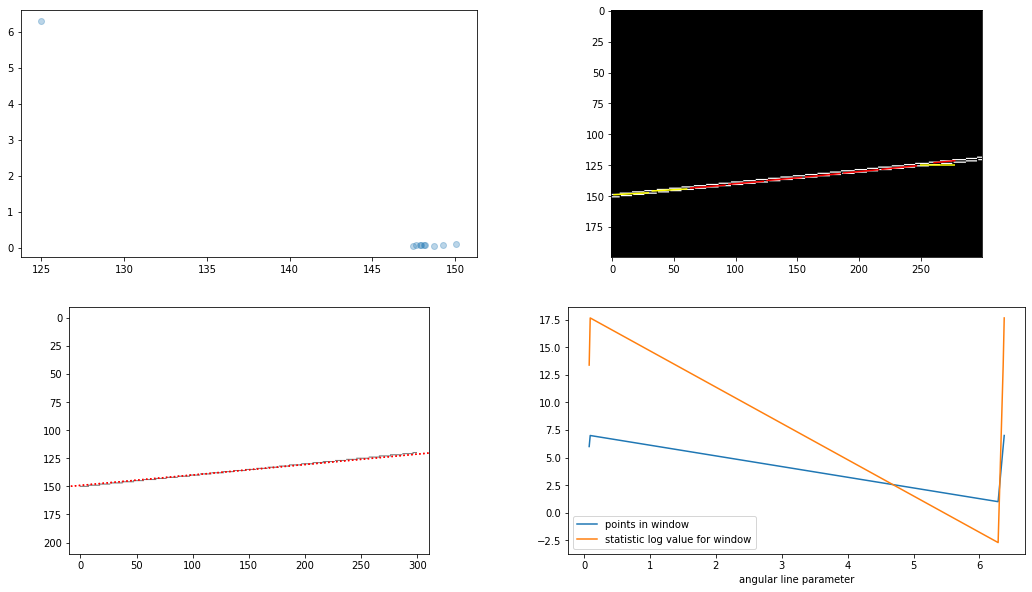

grid size:  32
miss cache
0.11459155902616464 6 18 20
miss cache
total
0.4034555368173801 6 6 8
0.11459155902616464 6 18 20
miss cache
total
0.40036197717421734 6 6 8
0.11459155902616464 6 18 20
miss cache
total
0.39115604925807146 6 6 8
0.11459155902616464 6 18 20
total
0.4034555368173801 6 6 8
0.11459155902616464 6 18 20
total
0.40036197717421734 6 6 8
0.11459155902616464 6 18 20
total
0.39115604925807146 6 6 8


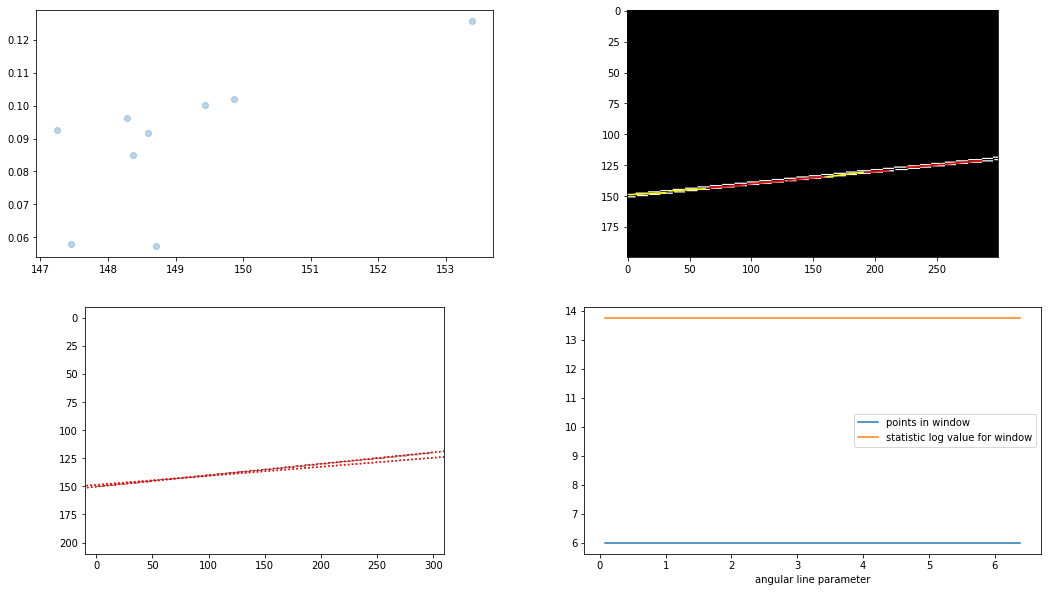

grid size:  33
miss cache
0.12732395447351627 5 20 22
miss cache
0.3362054637704984 4 5 7
0.3362054637704984 3 5 7
0.12732395447351627 5 20 22
miss cache
0.3353002668708282 3 5 7
0.3353002668708282 4 5 7
0.12732395447351627 5 20 22
miss cache
total
0.3328114867388809 5 5 7
0.12732395447351627 5 20 22
miss cache
total
0.331404151279165 5 5 7
0.12732395447351627 5 20 22
0.3362054637704984 4 5 7
0.3362054637704984 3 5 7
0.12732395447351627 5 20 22
0.3353002668708282 3 5 7
0.3353002668708282 4 5 7
0.12732395447351627 5 20 22
total
0.3328114867388809 5 5 7
0.12732395447351627 5 20 22
total
0.331404151279165 5 5 7


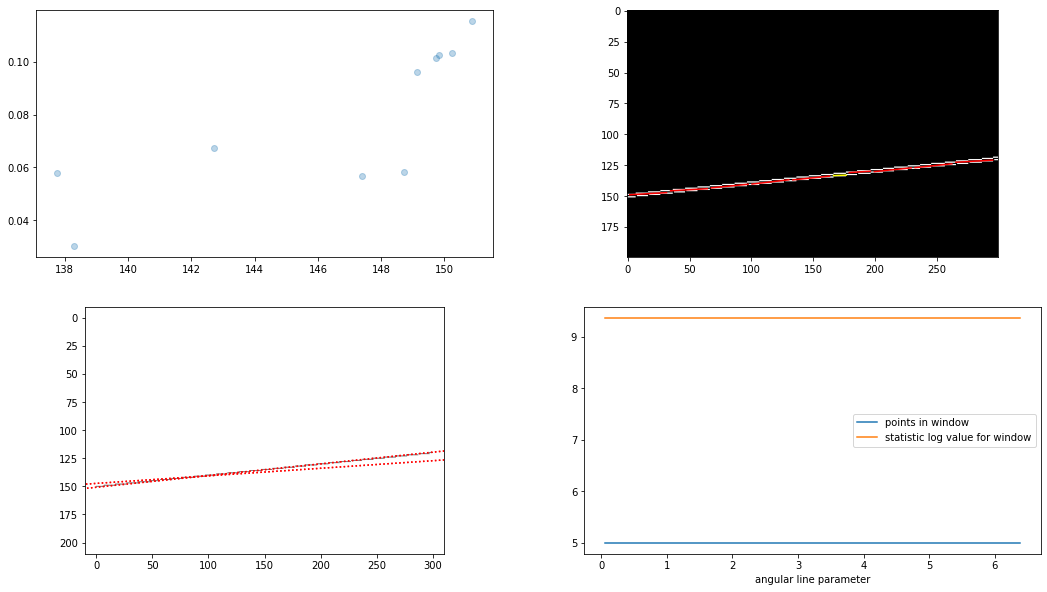

grid size:  34
miss cache
0.12732395447351627 5 20 22
miss cache
total
0.3362020286636777 5 5 7
0.12732395447351627 5 20 22
total
0.3362020286636777 5 5 7
0.12732395447351627 5 20 22
miss cache
total
0.3351494733858932 5 5 7
0.12732395447351627 5 20 22
miss cache
total
0.3336553825917387 5 5 7
0.12732395447351627 6 20 22
miss cache
total
0.39469235928922863 6 6 8
0.12732395447351627 5 20 22
total
0.3362020286636777 5 5 7
0.12732395447351627 5 20 22
total
0.3362020286636777 5 5 7
0.12732395447351627 5 20 22
total
0.3351494733858932 5 5 7
0.12732395447351627 5 20 22
total
0.3336553825917387 5 5 7
0.12732395447351627 6 20 22
total
0.39469235928922863 6 6 8


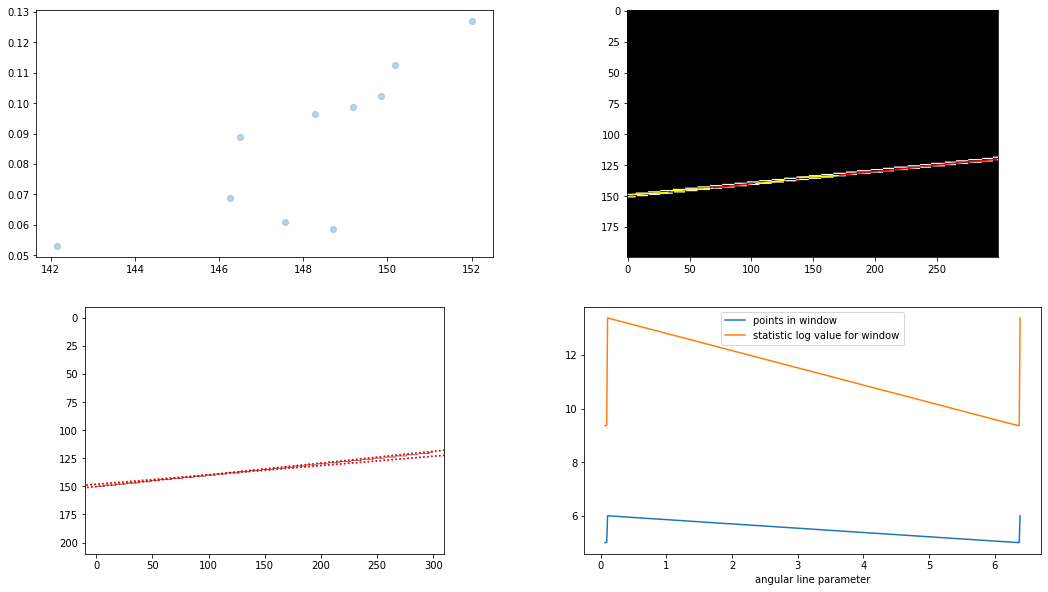

grid size:  35
miss cache
0.10185916357881303 5 16 18
miss cache
total
0.335136821803978 5 5 7
0.10185916357881303 6 16 18
miss cache
total
0.40096038666454586 6 6 8
0.10185916357881303 4 16 18
miss cache
total
0.2545131786159132 4 4 6
0.10185916357881303 5 16 18
total
0.335136821803978 5 5 7
0.10185916357881303 6 16 18
total
0.40096038666454586 6 6 8
0.10185916357881303 4 16 18
total
0.2545131786159132 4 4 6


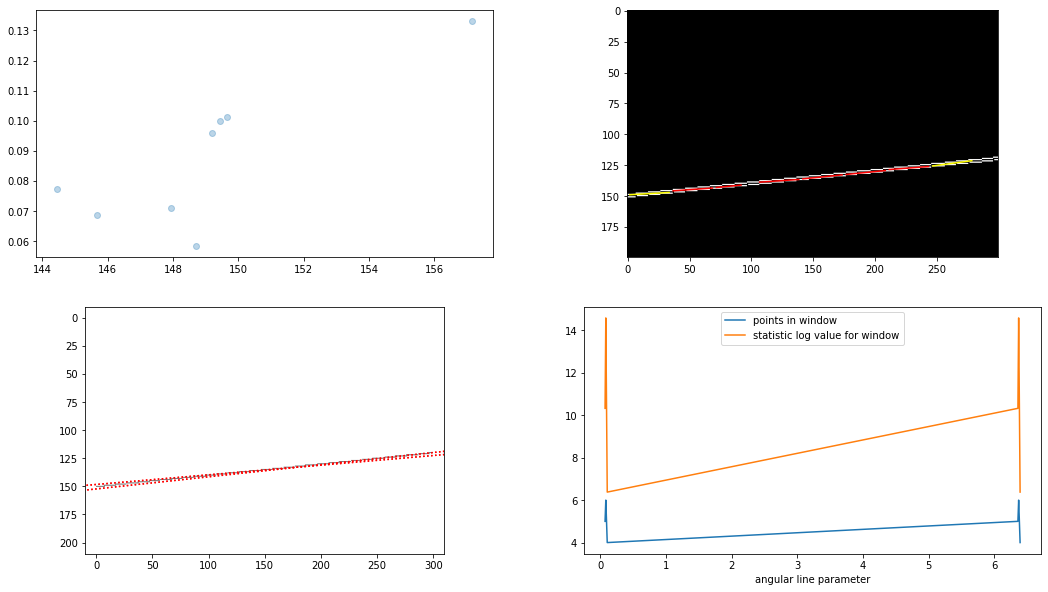

grid size:  36
miss cache
0.10185916357881303 1 16 18
0.10185916357881303 3 16 18
0.10185916357881303 6 16 18
miss cache
total
0.39543725866174356 6 6 8
0.10185916357881303 1 16 18
0.10185916357881303 3 16 18
0.10185916357881303 6 16 18
total
0.39543725866174356 6 6 8


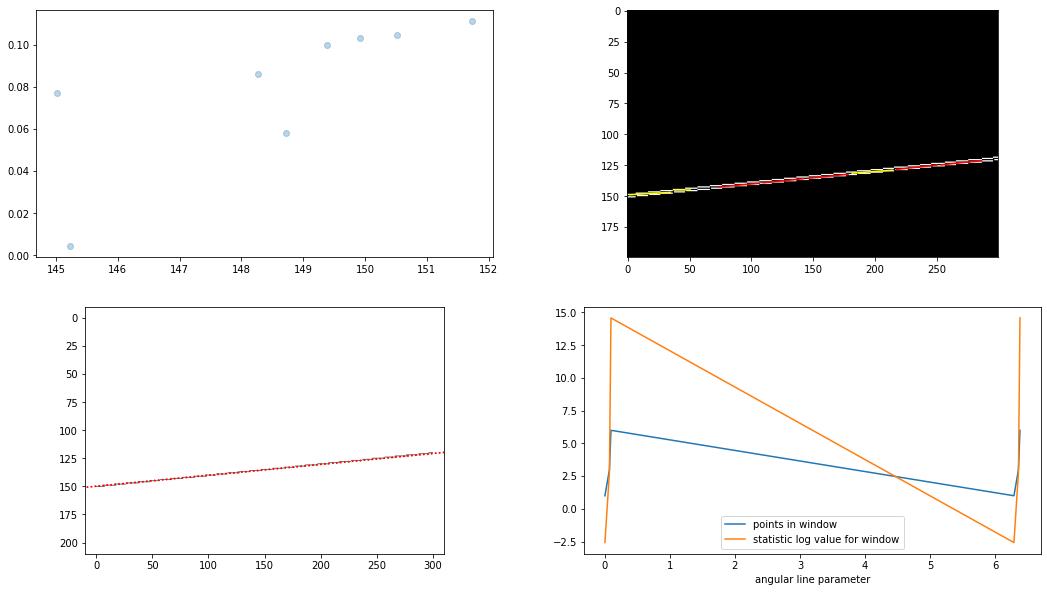

grid size:  37
miss cache
0.11459155902616464 4 18 20
miss cache
0.2664169835277876 1 4 6
0.2664169835277876 3 4 6
0.11459155902616464 8 18 20
miss cache
total
0.5297043935554178 8 8 10
0.11459155902616464 4 18 20
0.2664169835277876 1 4 6
0.2664169835277876 3 4 6
0.11459155902616464 8 18 20
total
0.5297043935554178 8 8 10


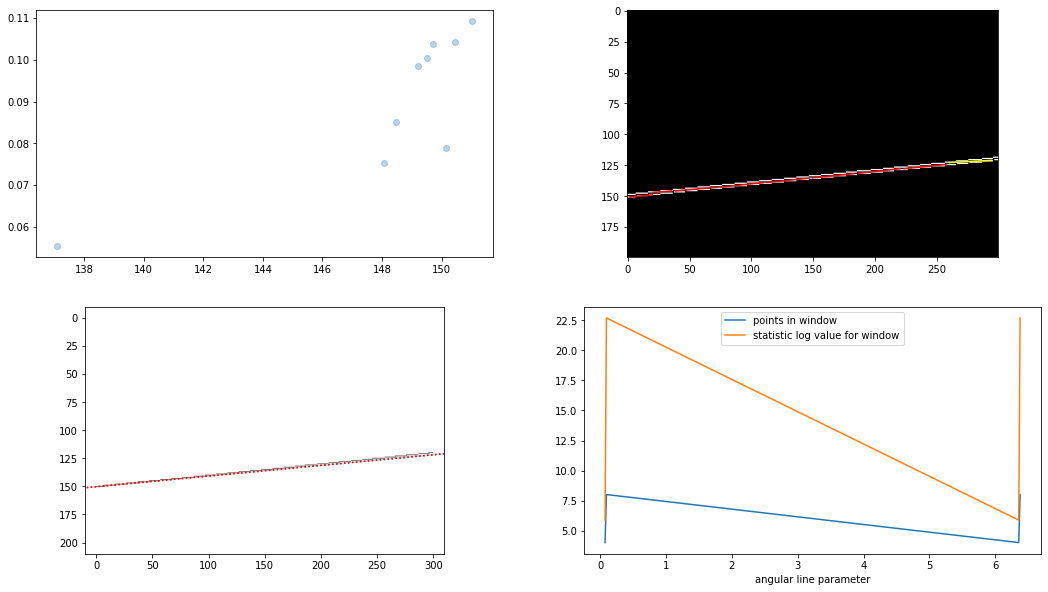

grid size:  38
miss cache
0.10185916357881303 6 16 18
miss cache
total
0.4004501367867631 6 6 8
0.10185916357881303 6 16 18
total
0.4004501367867631 6 6 8
0.10185916357881303 6 16 18
miss cache
total
0.39605544326195574 6 6 8
0.10185916357881303 6 16 18
total
0.4004501367867631 6 6 8
0.10185916357881303 6 16 18
total
0.4004501367867631 6 6 8
0.10185916357881303 6 16 18
total
0.39605544326195574 6 6 8


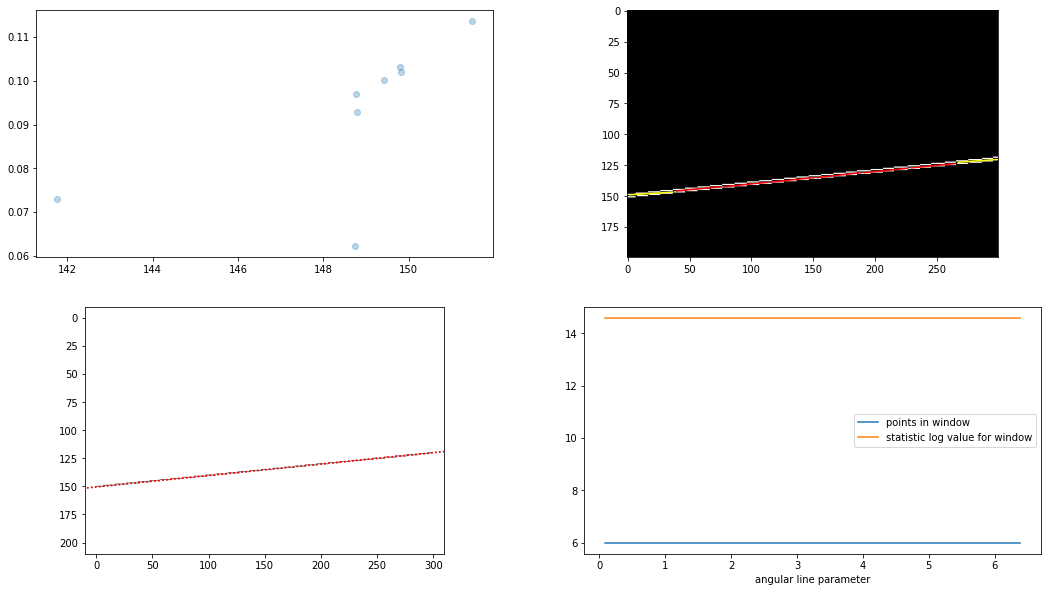

grid size:  39
miss cache
0.10185916357881303 6 16 18
miss cache
total
0.40054016227229083 6 6 8
0.10185916357881303 5 16 18
miss cache
total
0.32565710696356726 5 5 7
0.10185916357881303 5 16 18
total
0.32565710696356726 5 5 7
0.10185916357881303 6 16 18
total
0.40054016227229083 6 6 8
0.10185916357881303 5 16 18
total
0.32565710696356726 5 5 7
0.10185916357881303 5 16 18
total
0.32565710696356726 5 5 7


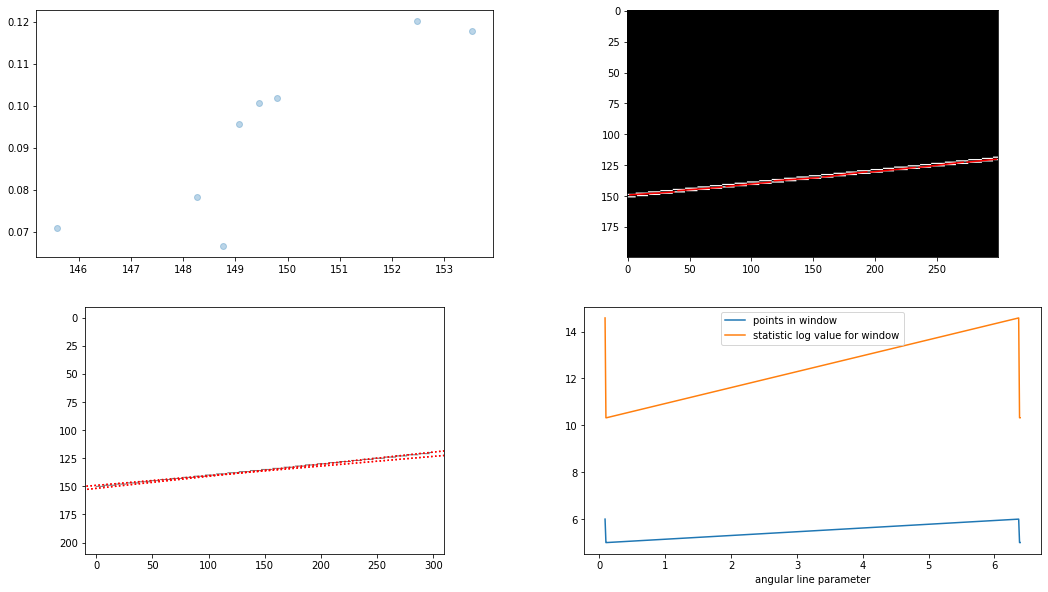

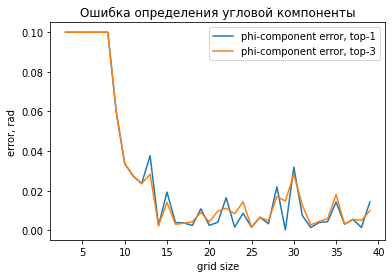

In [76]:
test_angle_accuracy(150, 0.1)

grid size:  3
miss cache
1.4514930809980857 96 228 230
miss cache
1.8150334490349889 8 96 98
1.8150334490349889 8 96 98
1.8150334490349889 8 96 98
1.8150334490349889 7 96 98
1.8150334490349889 7 96 98
1.8150334490349889 7 96 98
1.8150334490349889 7 96 98
1.8150334490349889 7 96 98
1.8150334490349889 8 96 98
1.8150334490349889 10 96 98
1.8150334490349889 9 96 98
1.8150334490349889 9 96 98
1.8150334490349889 10 96 98
1.8150334490349889 10 96 98
1.8150334490349889 11 96 98
1.8150334490349889 7 96 98
1.8150334490349889 7 96 98
1.8150334490349889 6 96 98
1.8150334490349889 6 96 98
1.8150334490349889 6 96 98
1.8150334490349889 6 96 98
1.8150334490349889 6 96 98
1.8150334490349889 6 96 98
1.8150334490349889 7 96 98
1.8150334490349889 8 96 98
1.8150334490349889 8 96 98
1.8150334490349889 7 96 98
1.8150334490349889 5 96 98
1.8150334490349889 5 96 98
1.8150334490349889 6 96 98
1.8150334490349889 5 96 98
1.8150334490349889 5 96 98
1.8150334490349889 5 96 98
1.8150334490349889 5 96 98
1.8150334490

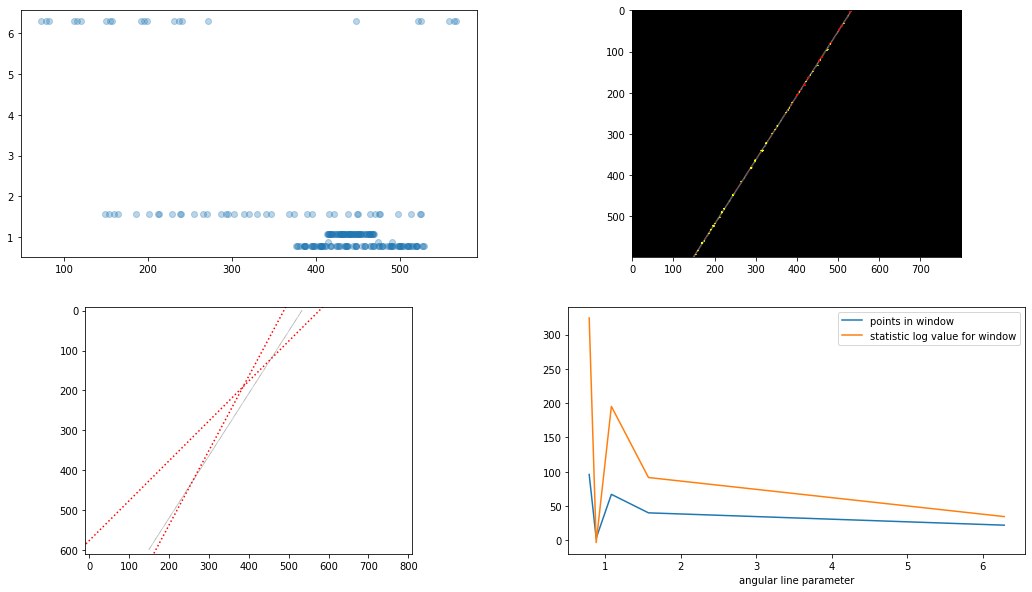

NameError: name 'top1_error' is not defined

In [70]:
test_angle_accuracy(450, 1, 600, 800)

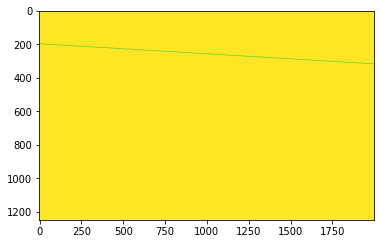

In [51]:
img = generate_image([Line(200, -0.06, 1, 0)], h=1250, w=2000)
plt.imshow(img)

miss cache
1.1618310845708362 75 146 148
miss cache
7.537959523649558 8 75 77
7.537959523649558 10 75 77
7.537959523649558 14 75 77
7.537959523649558 12 75 77
7.537959523649558 13 75 77
7.537959523649558 9 75 77
7.537959523649558 9 75 77
7.537959523649558 9 75 77
7.537959523649558 11 75 77
7.537959523649558 14 75 77
7.537959523649558 20 75 77
7.537959523649558 20 75 77
7.537959523649558 20 75 77
7.537959523649558 22 75 77
7.537959523649558 22 75 77
7.537959523649558 22 75 77
7.537959523649558 26 75 77
7.537959523649558 25 75 77
7.537959523649558 23 75 77
7.537959523649558 23 75 77
7.537959523649558 25 75 77
7.537959523649558 26 75 77
7.537959523649558 26 75 77
7.537959523649558 33 75 77
7.537959523649558 33 75 77
7.537959523649558 35 75 77
7.537959523649558 34 75 77
1.1618310845708362 67 146 148
miss cache
5.977015191601431 7 67 69
5.977015191601431 8 67 69
5.977015191601431 16 67 69
5.977015191601431 18 67 69
5.977015191601431 18 67 69
5.977015191601431 21 67 69
5.977015191601431 20 6

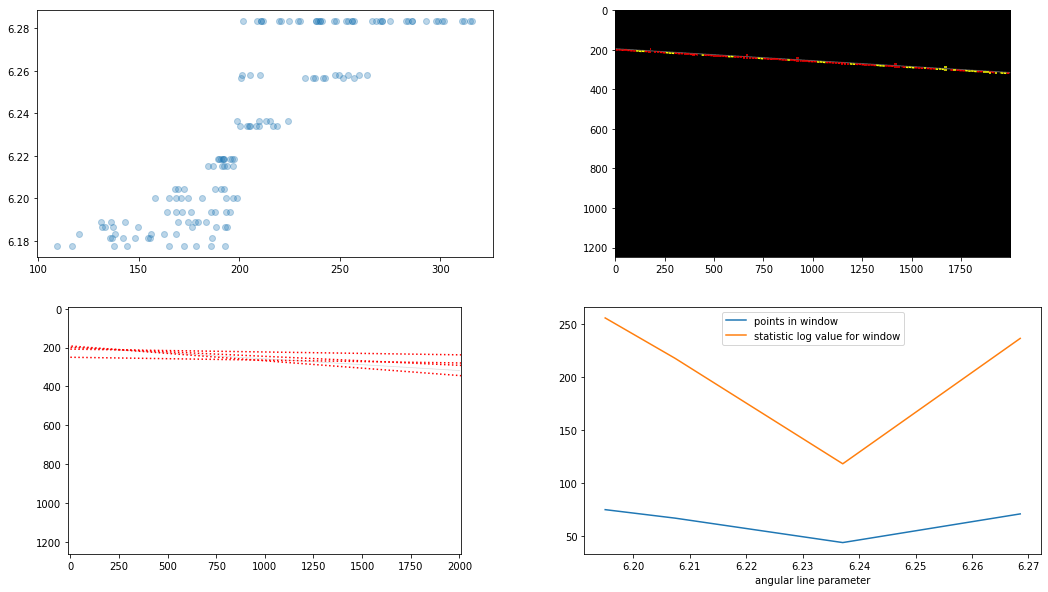

In [52]:
#img = generate_image([Line(150, 1, 1, 0)])

exp_data = run_exp(img, grid_size=15, 
                   polarization_method=MaxComponentInertionPolarization(10),
                   peak_detection_method=NausWallenstein(alpha=0.1, r_window=20))
exp_data.visualize(compact=True)    


errors:  (8.634783596594815, 0.01580464694674344)


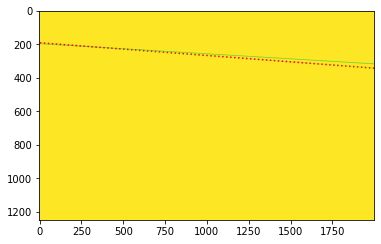

In [42]:


peaks = list(exp_data.peaks.items())
line = min(peaks, key=lambda x: x[1])
print("errors: ", count_line_error(line[0], (200, -0.06)))
plt.imshow(img)
draw_r_phi(line[0])

In [32]:
np.linalg.eig(np.array(
[
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1]
]))

(array([ 1., -1.,  1.]),
 array([[ 0.70710678, -0.70710678,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))